# Unsupervised concept drift detectors: SyncStream & SCD



In [1]:
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

import numpy as np
import math
from sklearn.decomposition import PCA
from scipy.stats import rankdata, norm, gaussian_kde
from sklearn.utils import resample
from statistics import variance

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from time import time

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import sklearn
import category_encoders
import scipy

print(sklearn.__version__)
print(category_encoders.__version__)
print(scipy.__version__)

1.0.2
2.5.1.post0
1.9.1


### Reading the SEA dataset

In [2]:
def read_sea(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
#     df = df.iloc[54450:55450,:] # For testing SCD with miniature scale
    
    X = df[["attrib1", "attrib2", "attrib3"]]
    
    X_train, X_test = train_test_split(X, train_size=0.30, shuffle=False)
    
    return X_train, X_test

### Reading the AGRAW dataset

In [3]:
def read_agraw(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)

    le = LabelEncoder()
#     te = TargetEncoder(cols=["elevel", "car", "zipcode"], smoothing=0, return_df=False)
#     ohe = OneHotEncoder()
#     oe = OrdinalEncoder()

    X = df.drop(columns=["class"])
    y = le.fit_transform(df["class"].str.decode("utf-8"))

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.30, shuffle=False)

#     encoder = 'target'
    
#     if encoder == 'onehot':
#         # OneHotEncoder
#         X_train_num = X_train.drop(columns=["elevel", "car", "zipcode"])
#         X_train_cat = X_train[["elevel", "car", "zipcode"]]
#         X_train_cat = ohe.fit_transform(X_train_cat).toarray()
#         X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
#         X_test_num = X_test.drop(columns=["elevel", "car", "zipcode"])
#         X_test_cat = X_test[["elevel", "car", "zipcode"]]
#         X_test_cat = ohe.transform(X_test_cat).toarray()
#         X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
#     elif encoder == 'ordinal':
#         # OrdinalEncoder
#         X_train_num = X_train.drop(columns=["elevel", "car", "zipcode"])
#         X_train_cat = X_train[["elevel", "car", "zipcode"]]
#         X_train_cat = oe.fit_transform(X_train_cat)
#         X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
#         X_test_num = X_test.drop(columns=["elevel", "car", "zipcode"])
#         X_test_cat = X_test[["elevel", "car", "zipcode"]]
#         X_test_cat = oe.transform(X_test_cat)
#         X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
#     elif encoder == 'target':
#         # TargetEncoder
#         X_train = te.fit_transform(X_train, y_train)
#         X_test = te.transform(X_test)
    
    return X_train, X_test, y_train, y_test

### Preprocessing

In [4]:
# def preprocess(X_train, X_test, total_batches):
#     scaler = MinMaxScaler()

#     X_train = pd.DataFrame(scaler.fit_transform(X_train))
#     X_test = pd.DataFrame(scaler.transform(X_test))

#     X_test_batches = np.array_split(X_test, total_batches)

#     return X_train, X_test_batches

def ensure_df(data):
    checked_data = data
    if not isinstance(data, pd.DataFrame):
        checked_data = pd.DataFrame(data)
    return checked_data

def encode(ref_data, test_batches, ref_labels, encoder=None):
    encoded_ref_data = ref_data
    encoded_test_batches = test_batches
    
    if encoder == 'onehot':
        # OneHotEncoder
        ohe = OneHotEncoder()
        ref_data_num = ref_data.select_dtypes(include=[np.number])
        ref_data_cat = ref_data.select_dtypes(exclude=[np.number])
        encoded_ref_data_cat = ohe.fit_transform(ref_data_cat).toarray()
        encoded_ref_data = pd.DataFrame(np.concatenate([ref_data_num, encoded_ref_data_cat], axis=1))
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            test_data_num = test_batches[batch].select_dtypes(include=[np.number])
            test_data_cat = test_batches[batch].select_dtypes(exclude=[np.number])
            encoded_test_data_cat = ohe.transform(test_data_cat).toarray()
            encoded_test_batches.append(pd.DataFrame(np.concatenate([test_data_num, encoded_test_data_cat], axis=1)))
    elif encoder == 'ordinal':
        # OrdinalEncoder
        oe = OrdinalEncoder()
        ref_data_num = ref_data.select_dtypes(include=[np.number])
        ref_data_cat = ref_data.select_dtypes(exclude=[np.number])
        encoded_ref_data_cat = oe.fit_transform(ref_data_cat)
        encoded_ref_data = pd.DataFrame(np.concatenate([ref_data_num, encoded_ref_data_cat], axis=1))
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            test_data_num = test_batches[batch].select_dtypes(include=[np.number])
            test_data_cat = test_batches[batch].select_dtypes(exclude=[np.number])
            encoded_test_data_cat = oe.transform(test_data_cat)
            encoded_test_batches.append(pd.DataFrame(np.concatenate([test_data_num, encoded_test_data_cat], axis=1)))
    elif encoder == 'target' and ref_labels is not None:
        # TargetEncoder
        cols = ref_data.select_dtypes(exclude=[np.number]).columns
        te = TargetEncoder(cols, smoothing=0, return_df=True)
        encoded_ref_data = te.fit_transform(ref_data, ref_labels)
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            encoded_test_batches.append(te.transform(test_batches[batch]))
        
    return encoded_ref_data, encoded_test_batches
    
def scale(ref_data, test_batches, scaler=None):
    scaled_ref_data = ref_data
    scaled_test_batches = test_batches
    
    if scaler == 'minmax':
        mms = MinMaxScaler()
        scaled_ref_data = pd.DataFrame(mms.fit_transform(ref_data))
        scaled_test_batches = list(map(lambda batch: pd.DataFrame(mms.transform(batch)), test_batches))
        
    return scaled_ref_data, scaled_test_batches

### Postprocessing

In [5]:
def postprocess(real_drift, detected_drifts, total_batches):
    if len(detected_drifts) <= 0:
        return 0.0, 1.0
    else:
        false_positives = list(filter(lambda flagged_batch: flagged_batch < real_drift, detected_drifts))
        false_positive_rate = len(false_positives) / (real_drift - 1)
        if false_positive_rate < 0:
            false_positive_rate = 0.0
            
        first_detected_drift = detected_drifts[0]
        for i in range(len(detected_drifts)):
            if detected_drifts[i] >= real_drift:
                first_detected_drift = detected_drifts[i]
                break
        latency = (first_detected_drift - real_drift) / (total_batches - real_drift)
        if latency < 0:
            latency = 1.0
            
        return false_positive_rate, latency
    
def postprocess_rw(real_drifts, detected_drifts, n_batches):
    if len(detected_drifts) <= 0:
        return 0.0, 0.0
    else:
        false_positives = list(filter(lambda detected_drift: detected_drift not in real_drifts, detected_drifts))
        correct_positives = list(filter(lambda real_drift: real_drift in detected_drifts, real_drifts))

        false_positive_rate = len(false_positives) / (n_batches - len(real_drifts))
        accuracy = len(correct_positives) / len(real_drifts)
        
        return false_positive_rate, accuracy
    
    
def graph(deltas, crits, y_label, deltas_reverse=None, crits_reverse=None):
    print(deltas)
    print(crits)
    print(y_label)
    print(deltas_reverse)
    print(crits_reverse)
    
    plt.ylabel(y_label)
    plt.xlabel("Test batch")
    x_range = np.arange(1, len(deltas) + 1)
    
    bar_width = 0.5
    offset = 0
    if deltas_reverse:
        bar_width = 0.25
        offset = 0.125
    
    plt.bar(x_range - offset, deltas, width=bar_width, color="b")
    plt.plot(x_range - offset, crits, "r-")
    if deltas_reverse:
        plt.bar(x_range + offset, deltas_reverse, width=bar_width, color="c")
        plt.plot(x_range + offset, crits_reverse, "m-")
        
    plt.show()

### SyncStream-PCA

In [6]:
def syncstream_pca_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, consecutive=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    print(test_batches[0].head())

    deltas = []
    crits = []
    drifts = []

    pca = PCA(n_components=1)

    pca.fit(ref_data.values)
    ref_eigenvector = pca.components_[0]

    for batch in range(len(test_batches)):
        pca.fit(test_batches[batch].values)
        batch_eigenvector = pca.components_[0]
        measured_angle = np.degrees(np.arccos(np.dot(batch_eigenvector, ref_eigenvector)))
        crit = 30
        
        if (consecutive):
            ref_eigenvector = batch_eigenvector
        
        deltas.append(measured_angle)
        crits.append(crit)
        if (measured_angle > crit):
            drifts.append(batch + 1)
    
    y_label = "SyncStream-PCA"
    if consecutive:
        y_label += " (consecutive)"
    else:
        y_label += " (fixed reference)"
    graph(deltas, crits, y_label)

    return drifts
    
def syncstream_pca(ref_data, test_data, ref_labels=None, encoder=None, scaler=None):
    drifts = syncstream_pca_all(ref_data, [test_data], ref_labels, encoder, scaler)
    return len(drifts) == 1
    

### SyncStream-Stat

In [7]:
def midrank(Dt, ranks_in_union, start_i, j):
    rank_sum = 0
    for i in range(start_i, start_i + len(Dt)):
        rank_sum += ranks_in_union[i]
    return rank_sum / len(Dt)

def v2(Dt, u, start_i):
    rank_diff_sum = 0
    for j in range(Dt.shape[1]):
        ranks_in_union = rankdata(u[:, j])
        ranks_in_Dt = rankdata(Dt[:, j])
        midrank_j = midrank(Dt, ranks_in_union, start_i, j)
        for i in range(0, len(Dt)):
            rank_diff_sum += (ranks_in_union[start_i + i] - ranks_in_Dt[i] - midrank_j + (len(Dt) + 1) / 2) ** 2
    return (1 / (len(Dt) - 1)) * rank_diff_sum

def midrank_diff(Dt, Dt1, u, j):
    ranks_in_union = rankdata(u[:, j])
    return midrank(Dt, ranks_in_union, 0, j) - midrank(Dt1, ranks_in_union, len(Dt), j)

def wilcoxon_test(Dt, Dt1, p):
    u = np.concatenate((Dt, Dt1))
    v2_Dt = v2(Dt, u, 0)
    v2_Dt1 = v2(Dt1, u, len(Dt))
    var_BF = (len(Dt) + len(Dt1)) * v2_Dt / len(Dt1) + (len(Dt) + len(Dt1)) * v2_Dt1 / len(Dt)
    sd_BF = np.sqrt(var_BF)
    midrank_diff_sum = 0
    for j in range(Dt.shape[1]):
        midrank_diff_sum += midrank_diff(Dt, Dt1, u, j)
    WBF = np.sqrt(len(Dt) * len(Dt1) / (len(Dt) + len(Dt1))) * midrank_diff_sum / sd_BF
    crit = norm.ppf(1-p/2)
    return abs(WBF) > crit, abs(WBF), crit

def syncstream_stat_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, p=0.01, consecutive=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
    
    print(test_batches[0].head())
    
    deltas = []
    crits = []
    drifts = []

    for batch in range(len(test_batches)):
        ref_batch = ref_data
        if consecutive and batch != 0:
            ref_batch = test_batches[batch - 1]
        detected_stat, delta, crit = wilcoxon_test(ref_batch.values, test_batches[batch].values, p)
        deltas.append(delta)
        crits.append(crit)
        if (detected_stat):
            drifts.append(batch + 1)
    
    y_label = "SyncStream-Stat"
    if consecutive:
        y_label += " (consecutive)"
    else:
        y_label += " (fixed reference)"
    graph(deltas, crits, y_label)
    
    return drifts

def syncstream_stat(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, p=0.01):
    drifts = syncstream_stat_all(ref_data, [test_data], ref_labels, encoder, scaler, p)
    return len(drifts) == 1

### SCD

In [8]:
# Gaussian kernel function

# def g_kernel(bandwidth, diff):
#     k = len(diff)
#     det = np.linalg.det(bandwidth)
#     inv = np.linalg.inv(bandwidth)
#     exponent_matrix = np.matmul(np.matmul(diff.T, inv), diff)
#     return (1 / (np.sqrt(2 * np.pi)**k * np.sqrt(det))) * np.exp((-1 / 2) * exponent_matrix)


# Learning bandwidths with Expectation Maximization

# def init_bandwidths(n, k):
#     print('n', n)
#     print('k', k)
#     bandwidths = []
#     for i in range(n):
#         bandwidths.append(np.identity(k))
#     return bandwidths

# def soft_membership(bandwidth, S1, i, j):
#     if i == j:
#         return 0
#     density_sum = 0
#     for t in range(len(S1)):
#         if t != j:
#             density_sum += g_kernel(bandwidth, S1[j] - S1[t])
#     return g_kernel(bandwidth, S1[j] - S1[i]) / density_sum

# def bandwidth_update(i, S1, bandwidths):
#     nominator_sum = np.zeros((len(S1[0]), len(S1[0])))
#     denominator_sum = 0
#     for j in range(len(S1)):
#         soft_mb = soft_membership(bandwidths[i], S1, i, j)
#         point_kernel_diff = S1[j] - S1[i]
#         nominator_sum += soft_mb * np.outer(point_kernel_diff, point_kernel_diff.T)
#         denominator_sum += soft_mb
#     return nominator_sum / denominator_sum

# def pseudo_LLH(S1, bandwidths):
#     LLH = 0
#     for j in range(len(S1)):
#         temp_sum = 0
#         for i in range(len(S1)):
#             if i != j:
#                 temp_sum += (1 / (len(S1) - 1)) * g_kernel(bandwidths[i], S1[j] - S1[i])
#         LLH += np.log(temp_sum)
#     return LLH

# def learn_bandwidths(S1, maxIteration, phi):
#     bandwidths = init_bandwidths(len(S1), len(S1[0]))
#     L = []
#     for t in range(maxIteration):
#         # compute density for all i, j
#         # compute soft membership for all i, j
#         # compute new bandwidth for all i
#         for i in range(len(bandwidths)):
#             bandwidths[i] = bandwidth_update(i, S1, bandwidths)
#         # compute L and check for stopping criterion
#         L.append(pseudo_LLH(S1, bandwidths))
#         print(L[t])
#         if t > 0:
#             if (((L[t] - L[t - 1]) / L[t - 1]) < phi):
#                 break
#     return bandwidths


# The test statistic

# def density_estimate(S1, bandwidths, s):
#     density = 0
#     for i in range(len(S1)):
#         density += (1 / len(S1)) * g_kernel(bandwidths[i], s - S1[i])
#     return density

# def log_likelihood(bandwidths, S1, data, kde):
#     LLH = 0
#     for y in range(len(data)):
#         LLH += np.log(density_estimate(S1, bandwidths, data[y]))
#     return LLH

def delta(S1, S2, Sprime, kde):
#     return log_likelihood(bandwidths, S1, Sprime, kde) 
#         - (len(Sprime) / len(S2)) * log_likelihood(bandwidths, S1, S2, kde)
    return np.sum(kde.logpdf(Sprime.T)) - (len(Sprime) / len(S2)) * np.sum(kde.logpdf(S2.T)) # drop-in replacement


# Determining the critical value
    
def est_var_estimates(S2, estSize, kde):
    est_time = time()
    Est = []
    std_prev_t = 0.0
    for t in range(estSize):
        R = resample(S2)
#         print("resampling done at", time() - est_var_timer, "seconds")
#         densities = map(lambda x: np.log(density_estimate(S1, bandwidths, x)), R)
        densities = kde.logpdf(R.T) # drop-in replacement
#         print("densities computed at", time() - est_var_timer, "seconds")
        Est.append((len(S2) / (len(S2) - 1)) * variance(densities))
        
        # stopping criterion after 30 estimates if their SD stabilizes within 1 percent
        std_current_t = np.std(Est)
        diff_std = float('inf')
        if t > 1:
            diff_std = abs(std_prev_t - std_current_t) / std_prev_t
        print("t", t, 
              "mean:", round(np.mean(Est), 5), 
              "std:", round(std_current_t, 5), 
              "diff_std:", round(diff_std, 5), 
              "time:", time() - est_time
             )
        if t >= 29 and diff_std < 0.01:
            break
        std_prev_t = std_current_t
        
    Est.sort()
    return Est

def critical_value(p, stepSize, S2_size, Sprime_size, kde, Est):
    M = math.floor(p / stepSize - 1)
    C = []
    for i in range(M):
        alpha = (i + 1) * stepSize
        beta = p - alpha
        # estimate variance for this beta:
        upper_limit = Est[math.ceil((len(Est) * (1 - beta) - 1))]
        var = (Sprime_size + Sprime_size**2/S2_size) * upper_limit
        # find c such that P(D <= c) = alpha, D ~ N(0, var):
        D = norm(0, np.sqrt(var))
        c = D.ppf(alpha)
        C.append(c)
    Cmax = np.amin(C)
    return Cmax


# Full procedure

def density_test(S1, S2, Sprime, p, kde, Est):
    # Calculate delta between S2 and S'
    d = delta(S1, S2, Sprime, kde)
    # Get critical value from S2
    stepSize = 0.002
    c = critical_value(p, stepSize, len(S2), len(Sprime), kde, Est)
    # Report drift if delta < critical value
    return d < c, d, c

def scd_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, p=0.08, bidirectional=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    print(test_batches[0].head())
    
    # Randomly partition the training set S into S1 and S2
    S1, S2 = train_test_split(ref_data, train_size=0.50, shuffle=True)
    
    # Use EM to learn the kernel model over S1
#     bandwidths = learn_bandwidths(S1.to_numpy(), maxIteration=100, phi=0.01)
    kde = gaussian_kde(S1.to_numpy().T) # drop-in replacement
    
    # Estimate the variance
    estSize = 4000
    Est = est_var_estimates(S2.to_numpy(), estSize, kde)
    
    deltas = []
    crits = []
    deltas_reverse = []
    crits_reverse = []
    drifts = []
    
    # Consider each test batch S':
    for batch in range(len(test_batches)):
        p_value = p
        if bidirectional:
            p_value = p/2
            
        detected_scd, delta, crit = density_test(
            S1.to_numpy(), 
            S2.to_numpy(), 
            test_batches[batch].to_numpy(), 
            p_value, 
            kde, 
            Est
        )
        deltas.append(delta)
        deltas_reverse.append(0)
        crits.append(crit)
        crits_reverse.append(0)
        if detected_scd:
            drifts.append(batch + 1)
            
        # If no drift was detected, run again with S and S' reversed
        elif bidirectional:
            print("Running in reverse for batch", batch)
            S1_reverse, S2_reverse = train_test_split(test_batches[batch], train_size=0.50, shuffle=True)
            
            # Use EM to learn the kernel model over S1
        #     bandwidths = learn_bandwidths(S1.to_numpy(), maxIteration=100, phi=0.01)
            kde_reverse = gaussian_kde(S1_reverse.to_numpy().T) # drop-in replacement
            
            # Estimate the variance
            Est_reverse = est_var_estimates(S2_reverse.to_numpy(), estSize, kde_reverse)
            
            detected_scd_reverse, delta_reverse, crit_reverse = density_test(
                S1_reverse.to_numpy(), 
                S2_reverse.to_numpy(), 
                ref_data.to_numpy(), 
                p_value, 
                kde_reverse, 
                Est_reverse
            )
            deltas_reverse[batch] = delta_reverse
            crits_reverse[batch] = crit_reverse
            if detected_scd_reverse:
                drifts.append(batch + 1)
    
    y_label = "SCD"
    if bidirectional:
        y_label += " (bidirectional)"
        graph(deltas, crits, y_label, deltas_reverse, crits_reverse)
    else:
        y_label += " (unidirectional)"
        graph(deltas, crits, y_label)
    
            
    return drifts

def scd(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, p=0.08, bidirectional=False):
    drifts = scd_all(ref_data, [test_data], ref_labels, encoder, scaler, p, bidirectional)
    return len(drifts) == 1

### Classifier detector

In [9]:
def classifier_detector_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, pca_preprocess=False):
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
        
    # Limit ref data first to two times the size of the first test batch
    ref_data = ref_data.tail(2 * len(test_batches[0]))
    print(len(ref_data))
    if ref_labels is not None:
        ref_labels = ref_labels[-(2 * len(test_batches[0])):]
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    if pca_preprocess:
        print("preprocessing with PCA")
        pca = PCA()
        ref_data = pd.DataFrame(pca.fit_transform(ref_data))
        preprocessed_test_batches = []
        for batch in range(len(test_batches)):
            preprocessed_test_batches.append(pd.DataFrame(pca.transform(test_batches[batch])))
        test_batches = preprocessed_test_batches
        
    print(test_batches[0].head())
    
    n_neighbors = int(len(ref_data) / 20)
    model = KNeighborsClassifier(n_neighbors)
    
    # Estimate accuracy variance by running cross-validation on randomly labeled ref data n times
    ref_accs = []
    half_point_ref_data = int(len(ref_data) / 2)
    ref_zero_labels = np.zeros(half_point_ref_data)
    ref_one_labels = np.ones(len(ref_data) - half_point_ref_data)
    ref_labels = np.concatenate([ref_zero_labels, ref_one_labels])
    for n in range(10):
        np.random.shuffle(ref_labels)
        score = cross_val_score(model, ref_data, ref_labels, cv=5).mean()
        print(score)
        ref_accs.append(score)
    print(ref_accs)
    print(np.std(ref_accs))
    crit = 0.5 + 2 * np.std(ref_accs)
    print(crit, "\n")
    
    # Now take equal-sized tail of ref data to go with the test batches
    ref_data = ref_data.tail(len(test_batches[0]))
    print(len(ref_data))
    
    # For each test batch, label it with ones, lump it together with reference data (labeled zeros)
    # and train a classifier on that.
    accuracies = []
    crits = []
    drifts = []
    for batch in range(len(test_batches)):
        zero_labels = np.zeros(len(ref_data))
        one_labels = np.ones(len(test_batches[batch]))
        X = np.concatenate([ref_data.values, test_batches[batch].values])
        y = np.concatenate([zero_labels, one_labels])
        score = cross_val_score(model, X, y, cv=5).mean()
        print(score)
        accuracies.append(score)
        crits.append(crit)
        if (score > crit):
            drifts.append(batch + 1)
            
    
    # Cross-validation accuracy of the classifier is our test statistic:
    # too high accuracy means the model is able to separate the batches.
    graph(accuracies, crits, "Classifier detector")
    
    return drifts

def classifier_detector(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, pca_preprocess=False):
    drifts = classifier_detector_all(ref_data, [test_data], ref_labels, encoder, scaler, pca_preprocess)
    return len(drifts) == 1

### Run synthetic datasets:

In [10]:
def run_detectors(X_train, X_test, y_train, filename, real_drift, n_batches, encoder, scaler, pca_preprocess=False):
    ref_data = X_train
    test_batches = np.array_split(X_test, n_batches)
    ref_labels = y_train
    
#     timer = time()
#     drifts_pca_ref = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_pca_all took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_ref = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_stat_all took", time() - timer, "seconds")
    
#     drifts_scd_unidir = []
#     if encoder != "onehot": # due to matrix errors
#         timer = time()
#         drifts_scd_unidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler)
#         print("scd_all took", time() - timer, "seconds")
        
#     timer = time()
#     drifts_pca_orig = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler, consecutive=True)
#     print("syncstream_pca_all (cons) took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_orig = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler, consecutive=True)
#     print("syncstream_stat_all (cons) took", time() - timer, "seconds")

#     drifts_scd_bidir = []
#     if encoder != "onehot": # due to matrix errors
#         drifts_scd_bidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler, bidirectional=True)

    timer = time()
    drifts_classifier = classifier_detector_all(ref_data, test_batches, ref_labels, encoder, scaler, pca_preprocess)
    print("classifier_detector_all took", time() - timer, "seconds")
    
    print("\n", filename, "encoder:", encoder, "scaler:", scaler, "PCA preprocess:", pca_preprocess)
    report_1 = [
#         "PCA_ref:",
#         drifts_pca_ref,
#         postprocess(real_drift, drifts_pca_ref, n_batches),
#         "Stat_ref:",
#         drifts_stat_ref,
#         postprocess(real_drift, drifts_stat_ref, n_batches),
#         "SCD_unidir:",
#         drifts_scd_unidir,
#         postprocess(real_drift, drifts_scd_unidir, n_batches),
        "Classifier:",
        drifts_classifier,
        postprocess(real_drift, drifts_classifier, n_batches)
    ]
    report_2 = [
#         "PCA_orig:",
#         drifts_pca_orig,
#         postprocess(real_drift, drifts_pca_orig, n_batches),
#         "Stat_orig:",
#         drifts_stat_orig,
#         postprocess(real_drift, drifts_stat_orig, n_batches),
#         "SCD_bidir:",
#         drifts_scd_bidir,
#         postprocess(real_drift, drifts_scd_bidir, n_batches)
    ]
    
    print(*report_1)
    print(*report_2, "\n")
    

SEA_filenames = [
#     "synthetic_data/abrupt_drift/sea_1_abrupt_drift_0_noise_balanced.arff",
#     "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_1.arff",
#     "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_5.arff",
#     "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_05.arff",
#     "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_10.arff",
#     "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_20.arff"
]

for filename in SEA_filenames:
    X_train, X_test = read_sea(filename)
    run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler=None)
    run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler="minmax")
    run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler=None, pca_preprocess=True)
    run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler="minmax", pca_preprocess=True)
    
AGRAW_filenames = [
#     "synthetic_data/abrupt_drift/agraw1_1_abrupt_drift_0_noise_balanced.arff",
#     "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_1.arff",
#     "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_5.arff",
#     "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_05.arff",
#     "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_10.arff",
#     "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_20.arff",
#     "synthetic_data/abrupt_drift/agraw2_1_abrupt_drift_0_noise_balanced.arff",
#     "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_1.arff",
#     "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_5.arff",
#     "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_05.arff",
#     "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_10.arff",
#     "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_20.arff"
]

for filename in AGRAW_filenames:
    X_train, X_test, y_train, y_test = read_agraw(filename)
    print(X_train)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler=None)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler="minmax")
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler=None)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler="minmax")
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler=None)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler="minmax")
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler=None, pca_preprocess=True)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler="minmax", pca_preprocess=True)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler=None, pca_preprocess=True)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler="minmax", pca_preprocess=True)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler=None, pca_preprocess=True)
    run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler="minmax", pca_preprocess=True)

### Run real-world datasets:

         date  day    period  nswprice  nswdemand  vicprice  vicdemand  \
0      0.0000  2.0  0.000000  0.056443   0.439155  0.003467   0.422915   
1      0.0000  2.0  0.021277  0.051699   0.415055  0.003467   0.422915   
2      0.0000  2.0  0.042553  0.051489   0.385004  0.003467   0.422915   
3      0.0000  2.0  0.063830  0.045485   0.314639  0.003467   0.422915   
4      0.0000  2.0  0.085106  0.042482   0.251116  0.003467   0.422915   
...       ...  ...       ...       ...        ...       ...        ...   
45307  0.9158  7.0  0.914894  0.044224   0.340672  0.003033   0.255049   
45308  0.9158  7.0  0.936170  0.044884   0.355549  0.003072   0.241326   
45309  0.9158  7.0  0.957447  0.043593   0.340970  0.002983   0.247799   
45310  0.9158  7.0  0.978723  0.066651   0.329366  0.004630   0.345417   
45311  0.9158  7.0  1.000000  0.050679   0.288753  0.003542   0.355256   

       transfer  label  
0      0.414912      1  
1      0.414912      1  
2      0.414912      1  
3      0.41

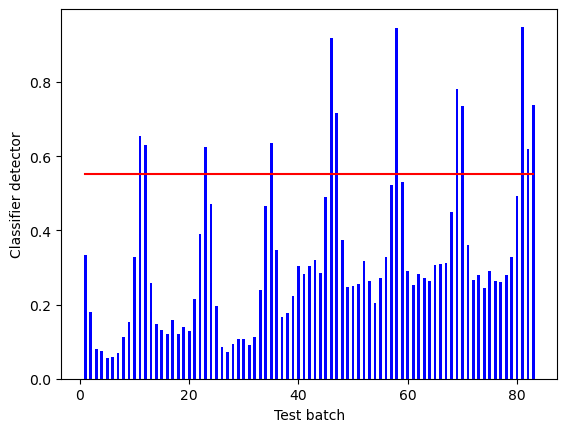

classifier_detector_all took 3.66302490234375 seconds

 real_world_data/electricity_dataset.csv encoder: None scaler: None
Classifier: [11, 12, 23, 35, 46, 47, 58, 69, 70, 81, 82, 83] (0.14814814814814814, 0.14285714285714285)


730
          0         1         2         3         4             5  \
0  0.999663  0.284492  0.506691  0.462260  0.151716 -1.429810e-30   
1  0.999586  0.270255  0.559235  0.516501  0.110770 -1.627026e-30   
2  0.999495  0.257109  0.619297  0.578832  0.112941 -1.602374e-30   
3  0.999429  0.242117  0.666966  0.627402  0.131635 -1.528418e-30   
4  0.999392  0.224942  0.699862  0.659704  0.142082 -1.503766e-30   

              6             7  
0  1.488200e-32  1.586995e-48  
1  1.488200e-32  1.586995e-48  
2  1.488200e-32  1.586995e-48  
3  1.488200e-32  1.586995e-48  
4  1.488200e-32  1.586995e-48  
0.48630136986301375
0.4726027397260274
0.4726027397260274
0.4684931506849315
0.47534246575342465
0.4821917808219179
0.44794520547945205
0.48356164383561645
0.48

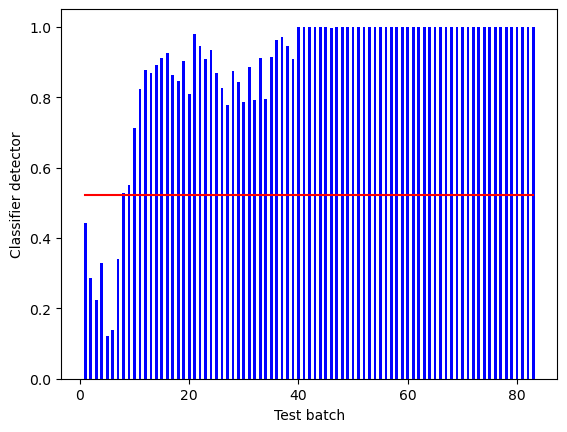

classifier_detector_all took 4.024060964584351 seconds

 real_world_data/electricity_dataset.csv encoder: None scaler: minmax
Classifier: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83] (0.8148148148148148, 0.9642857142857143)


60
           0          1         2         3         4         5         6  \
0  16.864053 -34.907169 -7.456566  0.853040  0.568902 -2.256625  0.831296   
1  24.989064 -36.876897 -8.011332 -0.517800  0.836812 -3.326491  1.493292   
2  28.013279 -47.105957 -3.949327  0.116105  3.673523  0.167558  1.090553   
3  30.262226 -51.233541 -0.611468 -0.789139  1.715592 -2.174101  0.888065   
4  34.244368 -57.969600  0.087914 -1.129572  3.154117 -0.370924 -0.222265   

          7  
0 -0.802144  
1 -1.217814  
2 -0.368

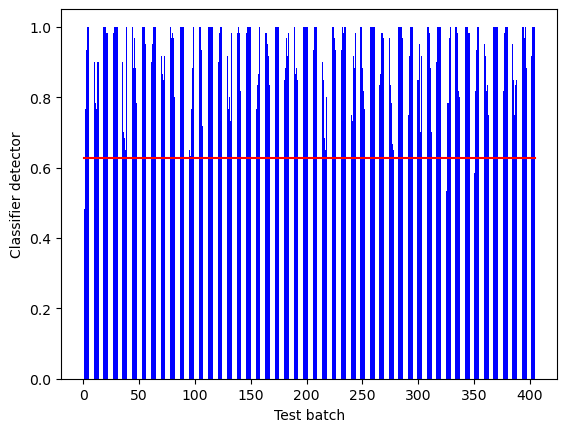

classifier_detector_all took 5.437013149261475 seconds

 real_world_data/weather_dataset.csv monthly encoder: None scaler: None
Classifier: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 

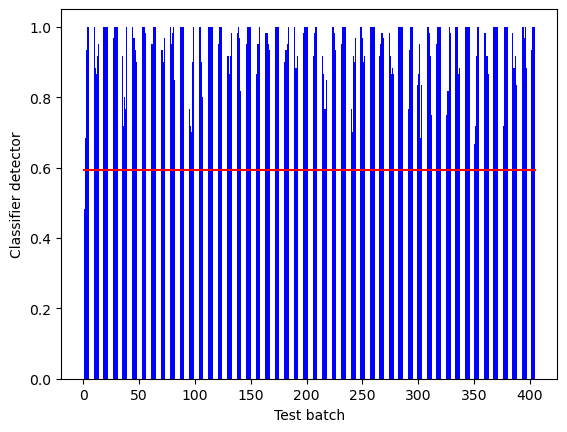

classifier_detector_all took 5.878044843673706 seconds

 real_world_data/weather_dataset.csv monthly encoder: None scaler: minmax
Classifier: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195

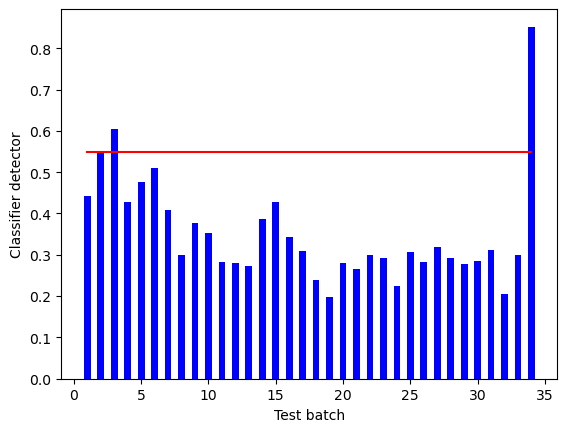

classifier_detector_all took 1.9179105758666992 seconds

 real_world_data/weather_dataset.csv yearly encoder: None scaler: None
Classifier: [3, 34] (0.0625, 0.05555555555555555)


730
          0         1         2         3         4         5         6  \
0  0.790127  0.160231  0.165091  0.470645  0.436661  0.341063  0.490701   
1  0.870072  0.148443  0.153488  0.434058  0.447343  0.287949  0.540101   
2  0.899829  0.087230  0.238443  0.450976  0.560452  0.461412  0.510048   
3  0.921957  0.062529  0.308253  0.426816  0.482383  0.345160  0.494938   
4  0.961139  0.022219  0.322881  0.417730  0.539742  0.434679  0.412083   

          7  
0  0.293858  
1  0.267473  
2  0.321380  
3  0.284549  
4  0.228511  
0.4589041095890411
0.48219178082191777
0.47671232876712333
0.5068493150684932
0.49863013698630143
0.4589041095890412
0.5397260273972603
0.4602739726027397
0.48219178082191777
0.5356164383561643
[0.4589041095890411, 0.48219178082191777, 0.47671232876712333, 0.5068493150684932, 0.49

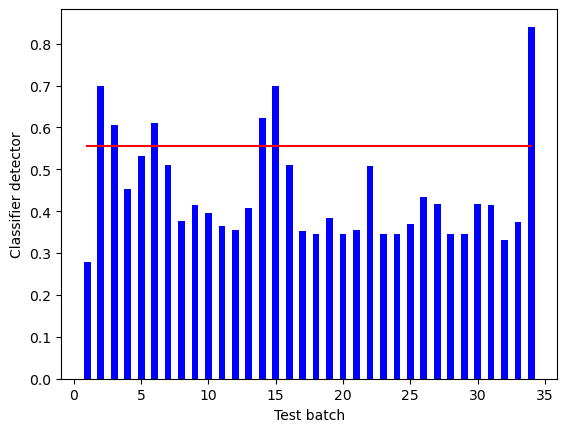

classifier_detector_all took 2.062983751296997 seconds

 real_world_data/weather_dataset.csv yearly encoder: None scaler: minmax
Classifier: [2, 3, 6, 14, 15, 34] (0.125, 0.2222222222222222)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.

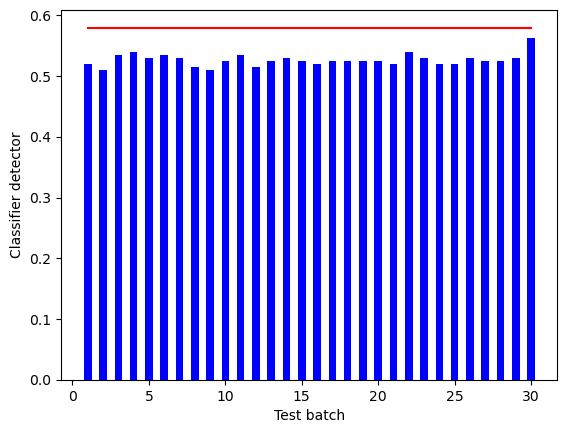

classifier_detector_all took 1.289499044418335 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


200
         0         1         2         3         4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.381649  0.348508  0.269519   
1  0.405538  0.257814  0.523115  0.401890  0.462930  0.361939  0.159060   
2  0.334286  0.374569  0.529598  0.381037  0.442400  0.434513  0.138164   
3  0.449808  0.549951  0.316738  0.474980  0.366269  0.399406  0.240680   
4  0.130201  0.386035  0.449649  0.460950  0.421609  0.453861  0.197006   

         7         8         9   ...        90        91        92        93  \
0  0.282439  0.454922  0.450021  ...  0.030105  0.469353  0.654362  0.877866   
1  0.222086  0.567438  0.395507  ...  0.498519  0.460366  0.436979  0.471717   
2  0.226394  0.452985  0.383655  ...  0.499423  0.556402  0.415777  0.541209   
3  0.199680  0.289608  0.509542  ...  0.675381  0.490150  0.644595  0.517183

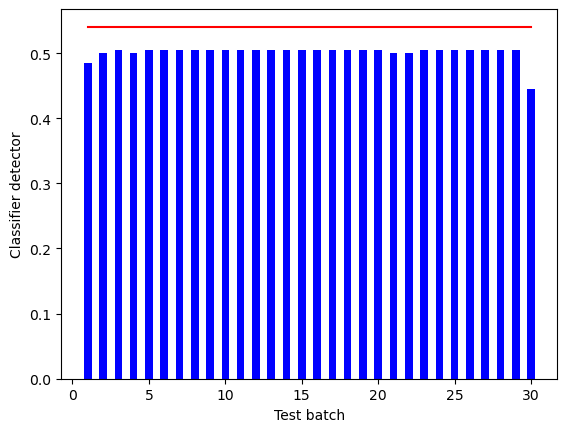

classifier_detector_all took 1.3607869148254395 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0

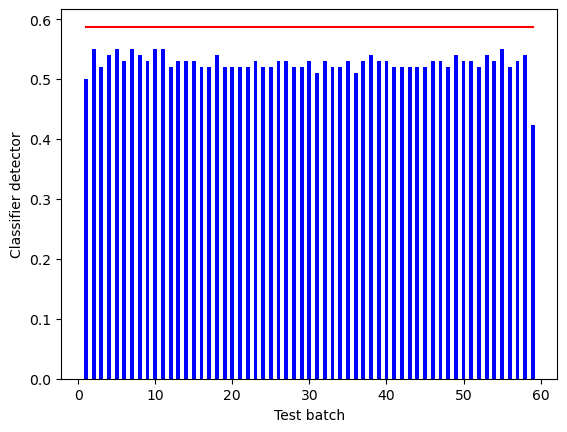

classifier_detector_all took 1.4465909004211426 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550653  0.662706  0.276326  0.635441   
1  0.396793  0.198283  0.552241  0.528499  0.803843  0.291245  0.375011   
2  0.322958  0.324403  0.559086  0.491263  0.768196  0.371859  0.325744   
3  0.442667  0.513852  0.334374  0.659010  0.636000  0.332862  0.567442   
4  0.111477  0.336788  0.474686  0.633958  0.732094  0.393351  0.464477   

         7         8         9   ...        90        91        92        93  \
0  0.469200  0.382284  0.570891  ...  0.305762  0.224873  1.008264  0.494671   
1  0.368940  0.509788  0.501726  ...  0.407945  0.348618  0.455393  0.375123   
2  0.376104  0.380081  0.486693  ...  0.658554  0.333974  0.636932  0.167871   
3  0.331720  0.194927  0.646387  ...  0.234297  0.309822  0.614582  0.352286

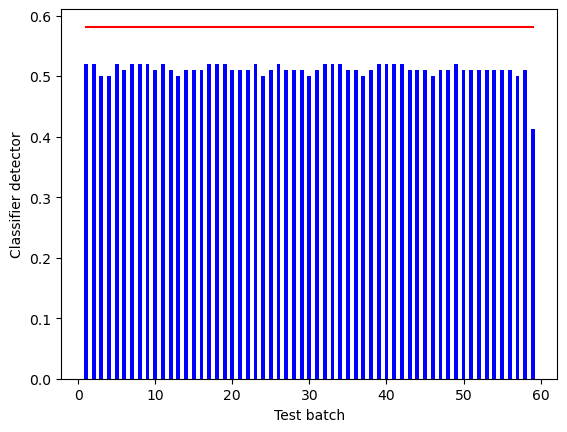

classifier_detector_all took 1.8302381038665771 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

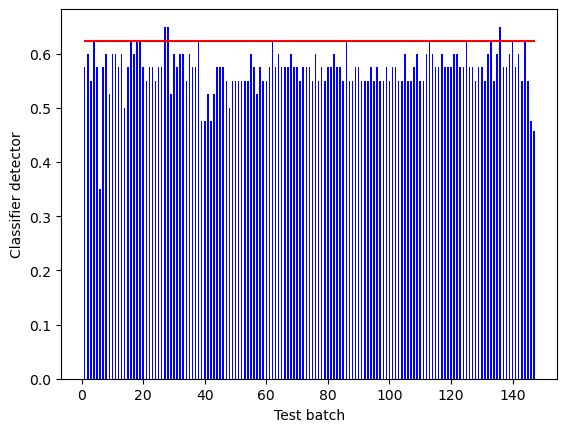

classifier_detector_all took 1.930490255355835 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [4, 16, 18, 19, 27, 28, 38, 62, 86, 113, 125, 133, 136, 140, 144] (0.14634146341463414, 0.08490566037735849)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583793  0.662706  0.435417  0.682715   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458925  0.331766   
2  0.427130  0.565700  0.559086  0.520829  0.768196  0.585953  0.265369   
3  0.585452  0.908633  0.334374  0.698671  0.636000  0.524503  0.591084   
4  0.147434  0.588120  0.474686  0.672112  0.732095  0.619816  0.452326   

         7         8         9   ...        90        91        92        93  \
0  0.494444  0.356643  0.610589  ...  0.050437 -0.045405  0.570294  0.606055   
1  0.388791  0.568536  0.533187  ...  0.504464  0.650649  0.492443  0.360114   
2  0.396337  0.352985  0.516379  ...  0.398205  0.333387  0.565

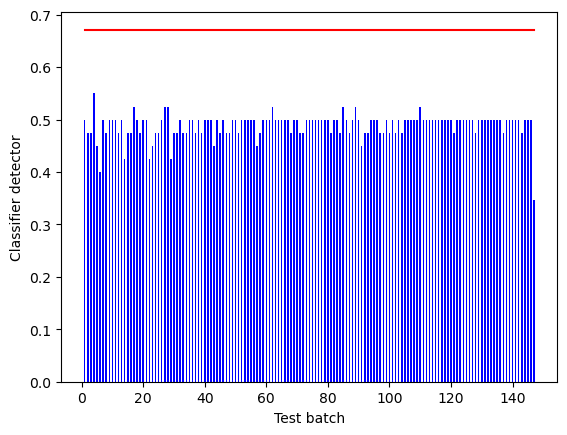

classifier_detector_all took 2.172171115875244 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0  

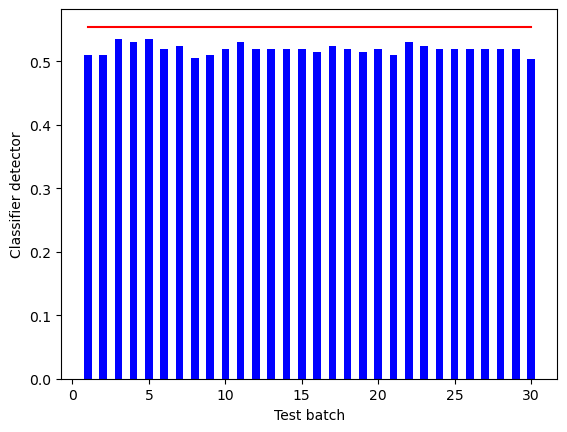

classifier_detector_all took 1.0944480895996094 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


200
         0         1         2         3        4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.38165  0.348509  0.269517   
1  0.405538  0.257814  0.523115  0.401890  0.46293  0.361940  0.159061   
2  0.334286  0.374569  0.529598  0.381037  0.44240  0.434513  0.138164   
3  0.449808  0.549951  0.316738  0.474980  0.36627  0.399407  0.240681   
4  0.130201  0.386035  0.449649  0.460950  0.42161  0.453861  0.197006   

         7         8         9   ...        90        91        92        93  \
0  0.282438  0.454928  0.450025  ...  0.659156  0.337673  0.450953  0.631385   
1  0.222083  0.567438  0.395508  ...  0.618239  0.612073  0.403830  0.408574   
2  0.226396  0.452985  0.383658  ...  0.603052  0.385228  0.438555  0.552330   
3  0.199679  0.289605  0.509541  ...  0.413958  0.589922  0.447679  0.460033   
4

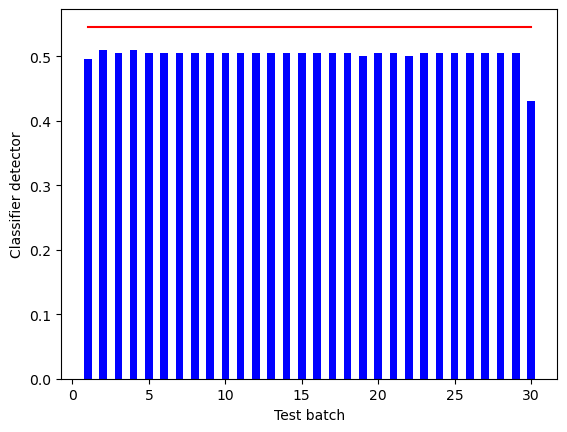

classifier_detector_all took 1.179962158203125 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

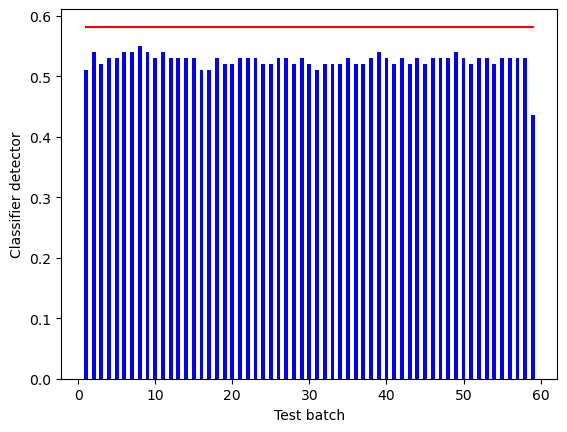

classifier_detector_all took 1.586374044418335 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550653  0.662707  0.276326  0.635437   
1  0.396793  0.198283  0.552241  0.528499  0.803844  0.291245  0.375011   
2  0.322958  0.324403  0.559086  0.491263  0.768196  0.371859  0.325746   
3  0.442667  0.513852  0.334374  0.659010  0.636001  0.332863  0.567443   
4  0.111477  0.336788  0.474686  0.633958  0.732095  0.393351  0.464475   

         7         8         9   ...        90        91        92        93  \
0  0.469199  0.382281  0.570880  ...  0.633802  0.175016  0.754530  0.766301   
1  0.368943  0.509787  0.501732  ...  0.496480  0.202139  0.485147  0.389330   
2  0.376102  0.380081  0.486691  ...  0.627966  0.550846  0.705966  0.468217   
3  0.331722  0.194926  0.646387  ...  0.477866  0.243293  0.673600  0.611822 

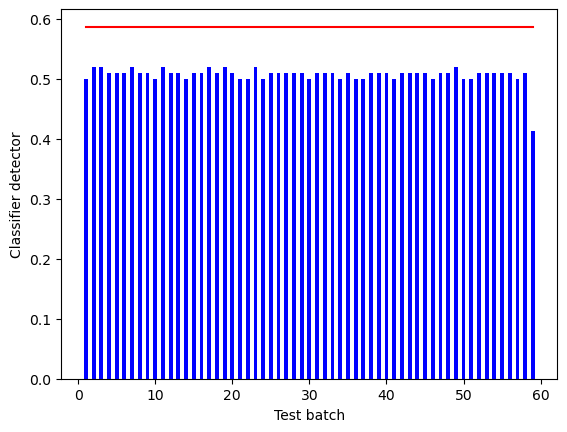

classifier_detector_all took 1.700423240661621 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0  

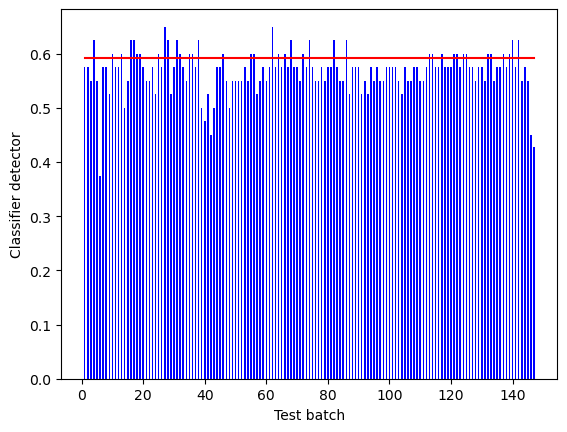

classifier_detector_all took 2.061244249343872 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [4, 10, 13, 16, 17, 18, 19, 25, 27, 28, 31, 32, 35, 36, 38, 46, 55, 56, 62, 64, 66, 68, 72, 74, 82, 86, 113, 114, 117, 121, 122, 124, 125, 132, 133, 137, 139, 140, 142] (0.2682926829268293, 0.2641509433962264)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583793  0.662706  0.435418  0.682713   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458925  0.331767   
2  0.427130  0.565700  0.559086  0.520828  0.768195  0.585950  0.265376   
3  0.585452  0.908633  0.334374  0.698670  0.635999  0.524503  0.591082   
4  0.147434  0.588120  0.474686  0.672112  0.732094  0.619815  0.452327   

         7         8         9   ...        90        91        92        93  \
0  0.494443  0.356634  0.610605  ...  0.462945  0.090512  0.448055  0.776475   
1  0.388793  0.568528  0.533190  ...  0.54

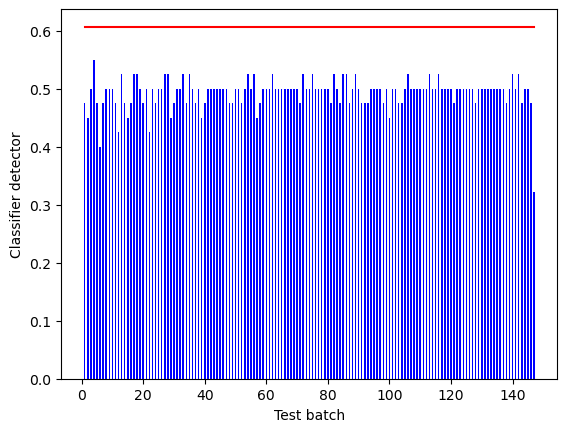

classifier_detector_all took 2.577183246612549 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0  

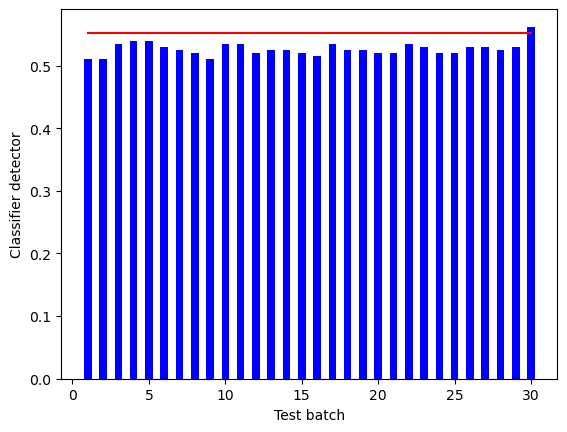

classifier_detector_all took 1.0384039878845215 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [30] (0.25, 0.0)


200
         0         1         2         3         4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.381649  0.348509  0.269520   
1  0.405538  0.257814  0.523115  0.401890  0.462930  0.361940  0.159060   
2  0.334286  0.374569  0.529598  0.381037  0.442400  0.434514  0.138162   
3  0.449808  0.549951  0.316738  0.474980  0.366269  0.399407  0.240679   
4  0.130201  0.386035  0.449649  0.460950  0.421610  0.453861  0.197006   

         7         8         9   ...        90        91        92        93  \
0  0.282436  0.454924  0.450026  ...  0.589386  0.626032  0.416870  0.565612   
1  0.222083  0.567436  0.395515  ...  0.377569  0.588630  0.566578  0.319164   
2  0.226392  0.452984  0.383656  ...  0.380431  0.495321  0.519632  0.344997   
3  0.199676  0.289606  0.509539  ...  0.341765  0.603328  0.509783  0.30

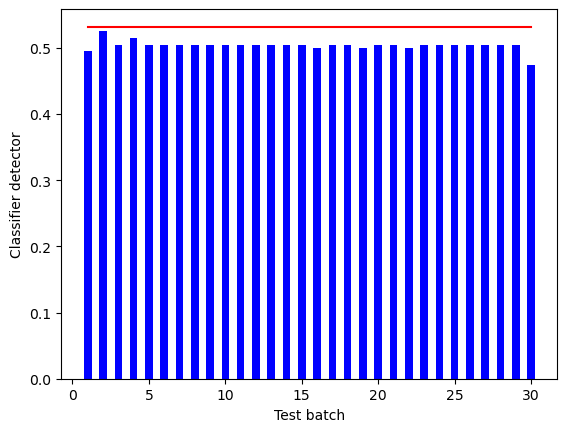

classifier_detector_all took 1.0858840942382812 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0

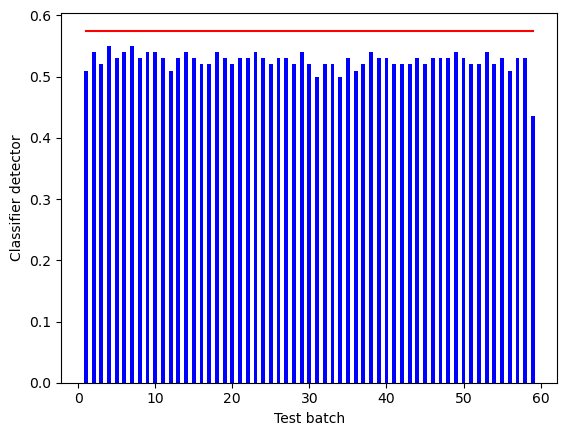

classifier_detector_all took 1.3820149898529053 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550653  0.662707  0.276326  0.635439   
1  0.396793  0.198283  0.552241  0.528499  0.803841  0.291245  0.375013   
2  0.322958  0.324403  0.559086  0.491263  0.768195  0.371858  0.325745   
3  0.442667  0.513852  0.334374  0.659010  0.636000  0.332862  0.567441   
4  0.111477  0.336788  0.474686  0.633958  0.732093  0.393350  0.464477   

         7         8         9   ...        90        91        92        93  \
0  0.469189  0.382279  0.570872  ...  0.363281  0.618421  0.071711  0.845226   
1  0.368937  0.509786  0.501725  ...  0.484248  0.671147  0.207600  0.482318   
2  0.376100  0.380079  0.486695  ...  0.442641  0.622900  0.319903  0.620602   
3  0.331720  0.194927  0.646387  ...  0.346634  0.647875  0.248064  0.530167

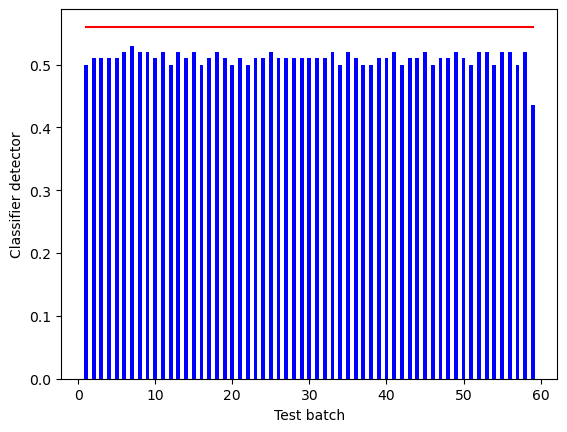

classifier_detector_all took 1.4889798164367676 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

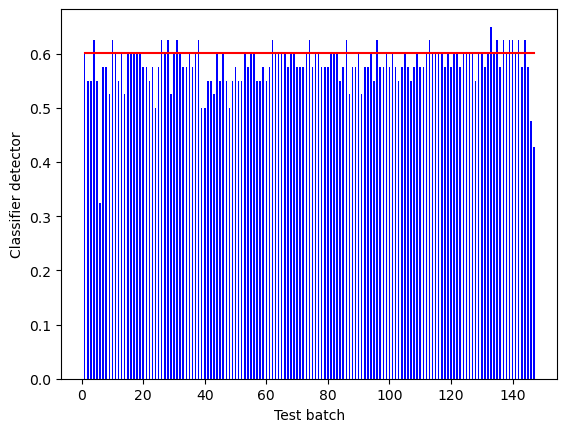

classifier_detector_all took 2.1566028594970703 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [4, 10, 26, 28, 31, 38, 62, 74, 86, 96, 113, 133, 135, 137, 139, 140, 142, 144] (0.0975609756097561, 0.1320754716981132)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583793  0.662705  0.435416  0.682712   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458926  0.331767   
2  0.427130  0.565700  0.559086  0.520829  0.768194  0.585951  0.265377   
3  0.585452  0.908633  0.334374  0.698671  0.636000  0.524502  0.591085   
4  0.147434  0.588120  0.474686  0.672112  0.732094  0.619815  0.452327   

         7         8         9   ...        90        91        92        93  \
0  0.494454  0.356647  0.610597  ...  0.742828  0.086291  0.671813  0.290425   
1  0.388793  0.568530  0.533182  ...  0.372924  0.379787  0.402614  0.447811   
2  0.396339  0.352979  0.516360  ...  0.686259  0.

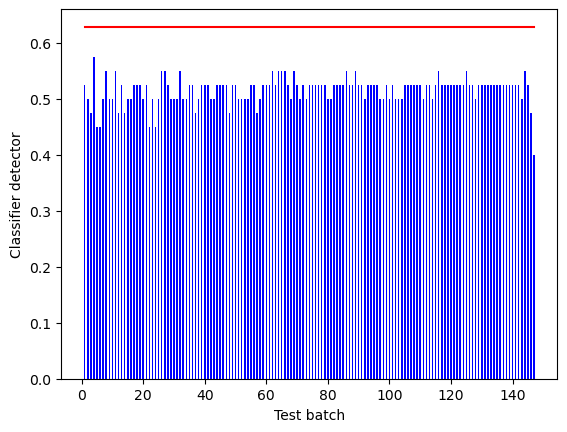

classifier_detector_all took 2.4208059310913086 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

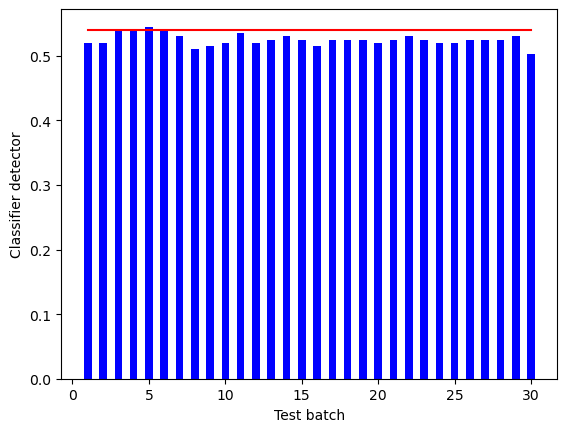

classifier_detector_all took 1.0119209289550781 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [5] (0.0, 0.038461538461538464)


200
         0         1         2         3         4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.381649  0.348511  0.269519   
1  0.405538  0.257814  0.523115  0.401890  0.462930  0.361940  0.159061   
2  0.334286  0.374569  0.529598  0.381037  0.442400  0.434513  0.138164   
3  0.449808  0.549951  0.316738  0.474980  0.366269  0.399408  0.240680   
4  0.130201  0.386035  0.449649  0.460950  0.421610  0.453861  0.197006   

         7         8         9   ...        90        91        92        93  \
0  0.282438  0.454926  0.450019  ...  0.477107  0.466658  0.110776  0.239515   
1  0.222085  0.567440  0.395513  ...  0.240661  0.327916  0.472300  0.526941   
2  0.226396  0.452985  0.383658  ...  0.394005  0.230930  0.571010  0.489967   
3  0.199681  0.289603  0.509542  ...  0.348720  0.555615 

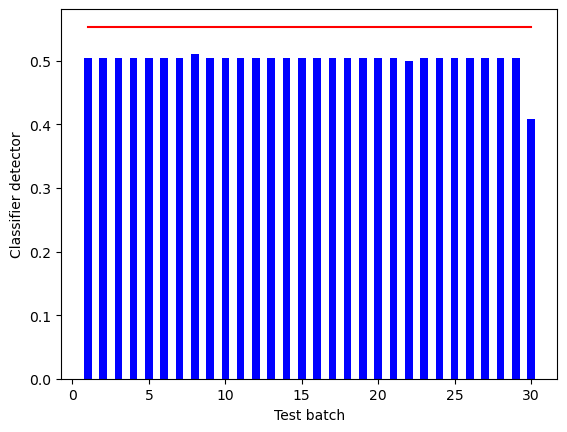

classifier_detector_all took 1.134871006011963 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

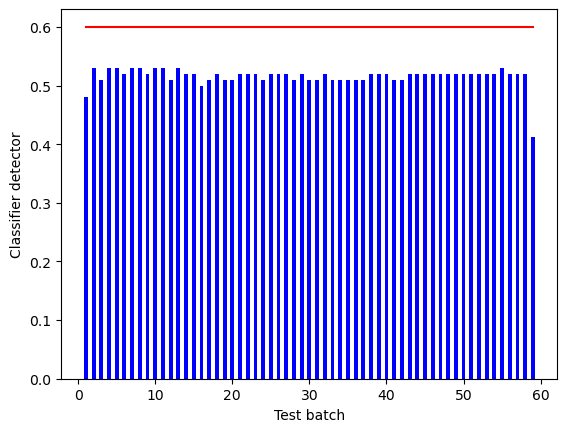

classifier_detector_all took 1.3386201858520508 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550653  0.662707  0.276328  0.635439   
1  0.396793  0.198283  0.552241  0.528499  0.803844  0.291246  0.375012   
2  0.322958  0.324403  0.559086  0.491263  0.768196  0.371860  0.325744   
3  0.442667  0.513852  0.334374  0.659010  0.636001  0.332864  0.567446   
4  0.111477  0.336788  0.474686  0.633959  0.732094  0.393351  0.464478   

         7         8         9   ...        90        91        92        93  \
0  0.469199  0.382285  0.570873  ...  0.384332  0.617525  0.776526  0.369457   
1  0.368942  0.509786  0.501722  ...  0.429017  0.667797  0.190529  0.357216   
2  0.376105  0.380084  0.486701  ...  0.667639  0.747447  0.368025  0.556918   
3  0.331723  0.194925  0.646389  ...  0.727748  0.745451  0.270926  0.435058

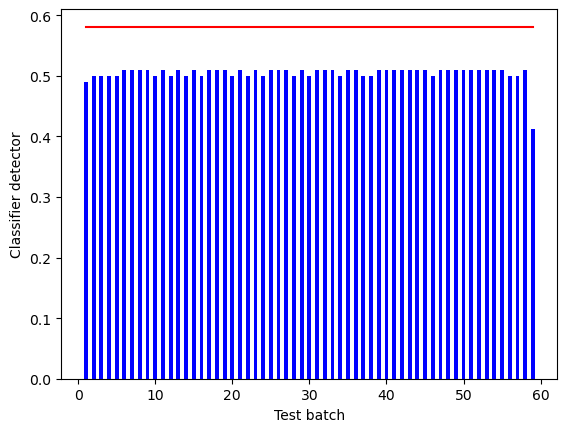

classifier_detector_all took 1.4557161331176758 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

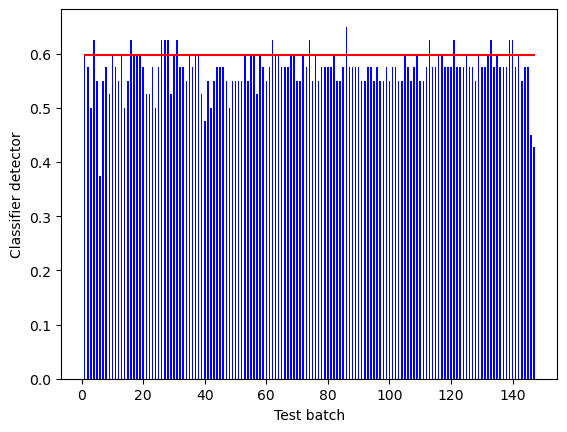

classifier_detector_all took 2.2860007286071777 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [1, 4, 10, 13, 16, 17, 18, 19, 26, 27, 28, 30, 31, 35, 37, 38, 53, 55, 56, 58, 62, 63, 64, 68, 69, 72, 74, 76, 82, 86, 105, 109, 113, 116, 117, 121, 125, 129, 132, 133, 135, 139, 140, 142] (0.2682926829268293, 0.3113207547169811)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325912  0.583793  0.662708  0.435419  0.682717   
1  0.524781  0.337404  0.552241  0.560305  0.803841  0.458923  0.331766   
2  0.427130  0.565700  0.559086  0.520829  0.768193  0.585950  0.265371   
3  0.585452  0.908633  0.334374  0.698671  0.635998  0.524502  0.591082   
4  0.147434  0.588120  0.474686  0.672112  0.732093  0.619815  0.452328   

         7         8         9   ...        90        91        92        93  \
0  0.494440  0.356632  0.610575  ...  0.517165  0.400958  0.791605  0.697506   
1  0.388791  0.568529

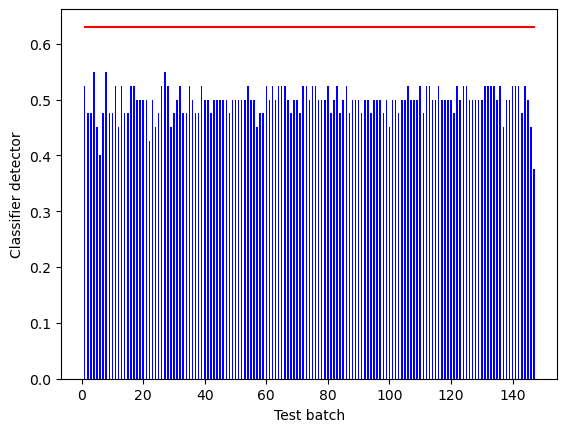

classifier_detector_all took 2.2445859909057617 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

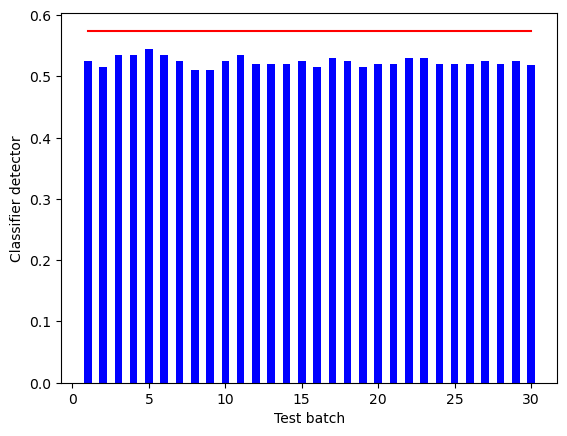

classifier_detector_all took 1.2749457359313965 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


200
         0         1         2         3         4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.381651  0.348510  0.269520   
1  0.405538  0.257814  0.523115  0.401890  0.462929  0.361940  0.159060   
2  0.334286  0.374569  0.529598  0.381037  0.442400  0.434513  0.138164   
3  0.449808  0.549951  0.316738  0.474980  0.366269  0.399407  0.240680   
4  0.130201  0.386035  0.449649  0.460950  0.421610  0.453860  0.197007   

         7         8         9   ...        90        91        92        93  \
0  0.282433  0.454923  0.450019  ...  0.671489  0.382662  0.876025  0.801133   
1  0.222083  0.567440  0.395509  ...  0.522822  0.496842  0.526119  0.384996   
2  0.226394  0.452984  0.383657  ...  0.482191  0.535566  0.949578  0.458629   
3  0.199677  0.289605  0.509542  ...  0.392948  0.350836  0.526377  0.44658

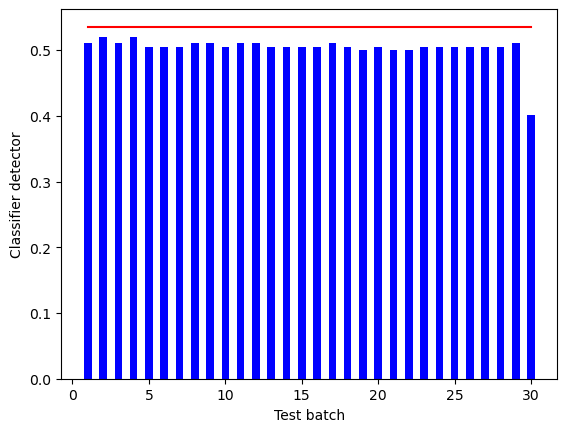

classifier_detector_all took 1.4545481204986572 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0

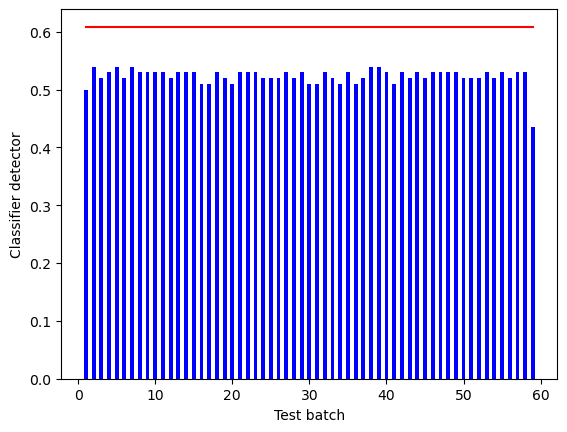

classifier_detector_all took 1.3147509098052979 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550654  0.662707  0.276327  0.635436   
1  0.396793  0.198283  0.552241  0.528499  0.803843  0.291245  0.375008   
2  0.322958  0.324403  0.559086  0.491263  0.768195  0.371859  0.325739   
3  0.442667  0.513852  0.334374  0.659010  0.635999  0.332863  0.567440   
4  0.111477  0.336788  0.474686  0.633959  0.732095  0.393351  0.464473   

         7         8         9   ...        90        91        92        93  \
0  0.469202  0.382279  0.570859  ...  0.809087  0.864923  0.396015  0.561060   
1  0.368943  0.509787  0.501723  ...  0.475136  0.583386  0.380455  0.542707   
2  0.376106  0.380075  0.486677  ...  0.513632  0.651422  0.527675  0.330034   
3  0.331720  0.194931  0.646397  ...  0.239771  0.573191  0.328656  0.327337

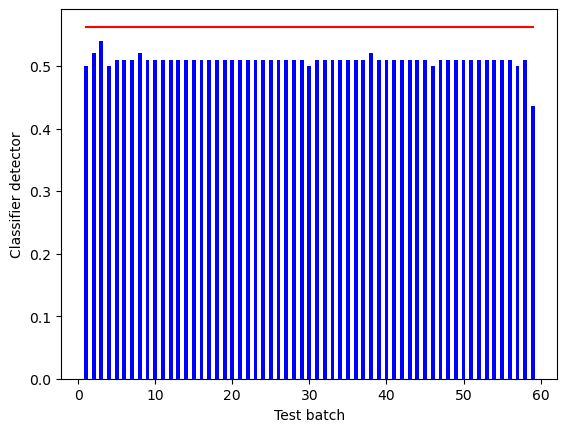

classifier_detector_all took 1.3571829795837402 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

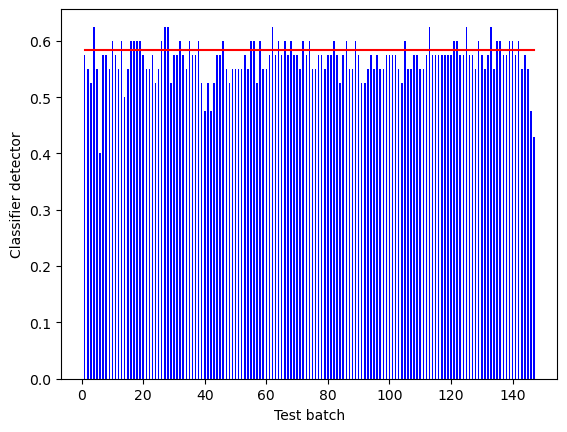

classifier_detector_all took 2.021127223968506 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [4, 10, 13, 16, 17, 18, 19, 26, 27, 28, 32, 35, 38, 46, 55, 56, 58, 62, 64, 66, 68, 72, 74, 82, 86, 89, 105, 113, 121, 122, 125, 129, 133, 135, 136, 139, 140, 142] (0.2682926829268293, 0.25471698113207547)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583793  0.662705  0.435416  0.682718   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458924  0.331766   
2  0.427130  0.565700  0.559086  0.520829  0.768194  0.585950  0.265374   
3  0.585452  0.908633  0.334374  0.698671  0.635999  0.524502  0.591086   
4  0.147434  0.588120  0.474686  0.672112  0.732094  0.619814  0.452327   

         7         8         9   ...        90        91        92        93  \
0  0.494442  0.356643  0.610593  ...  0.362281  0.303392  0.049516  1.147700   
1  0.388790  0.568525  0.533186  ...  0.607134

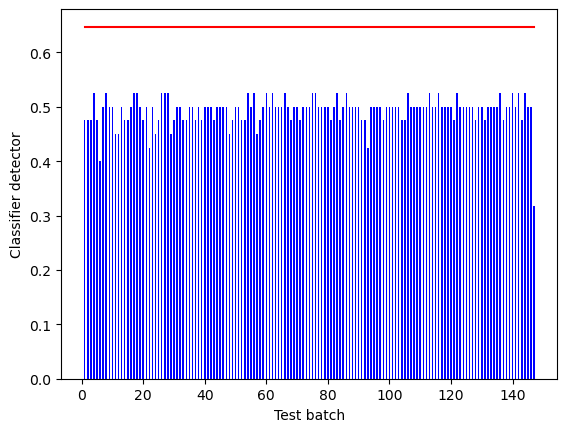

classifier_detector_all took 2.170228958129883 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0  

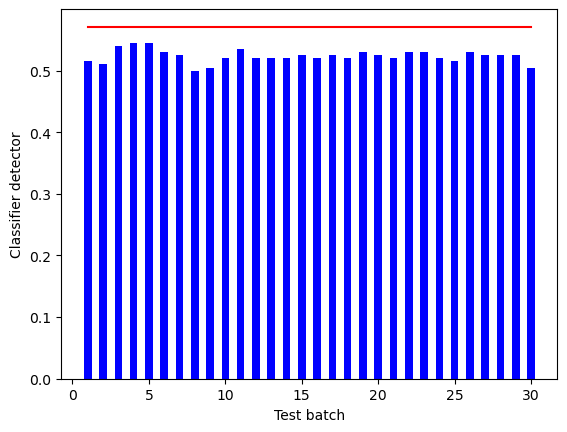

classifier_detector_all took 1.205946922302246 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


200
         0         1         2         3        4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.38165  0.348509  0.269520   
1  0.405538  0.257814  0.523115  0.401890  0.46293  0.361940  0.159060   
2  0.334286  0.374569  0.529598  0.381037  0.44240  0.434513  0.138164   
3  0.449808  0.549951  0.316738  0.474980  0.36627  0.399407  0.240679   
4  0.130201  0.386035  0.449649  0.460951  0.42161  0.453861  0.197006   

         7         8         9   ...        90        91        92        93  \
0  0.282430  0.454928  0.450024  ...  0.692071  0.761342  0.408156  0.125945   
1  0.222084  0.567439  0.395509  ...  0.577701  0.462223  0.297114  0.406828   
2  0.226396  0.452984  0.383662  ...  0.635455  0.405869  0.330249  0.285198   
3  0.199681  0.289604  0.509539  ...  0.466911  0.598825  0.288510  0.414599   
4 

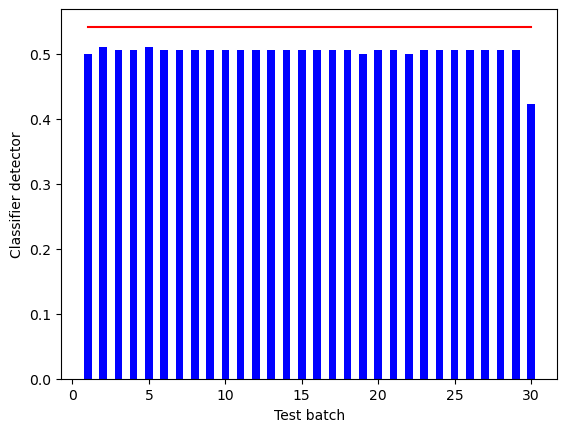

classifier_detector_all took 1.2453749179840088 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0

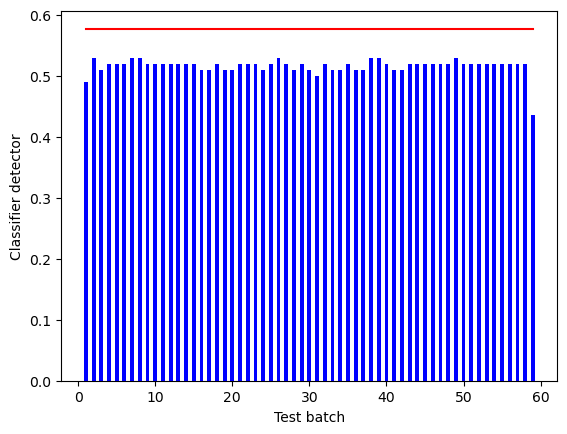

classifier_detector_all took 1.3120460510253906 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550654  0.662705  0.276326  0.635441   
1  0.396793  0.198283  0.552241  0.528499  0.803842  0.291244  0.375012   
2  0.322958  0.324403  0.559086  0.491263  0.768195  0.371858  0.325746   
3  0.442667  0.513852  0.334374  0.659010  0.636000  0.332862  0.567444   
4  0.111477  0.336788  0.474686  0.633958  0.732095  0.393350  0.464478   

         7         8         9   ...        90        91        92        93  \
0  0.469204  0.382279  0.570878  ...  0.796995  0.639510  0.660522 -0.018160   
1  0.368941  0.509787  0.501727  ...  0.385337  0.399388  0.525795  0.419151   
2  0.376104  0.380080  0.486703  ...  0.473377  0.336797  0.454042  0.204581   
3  0.331726  0.194925  0.646393  ...  0.692691  0.386483  0.594190  0.532870

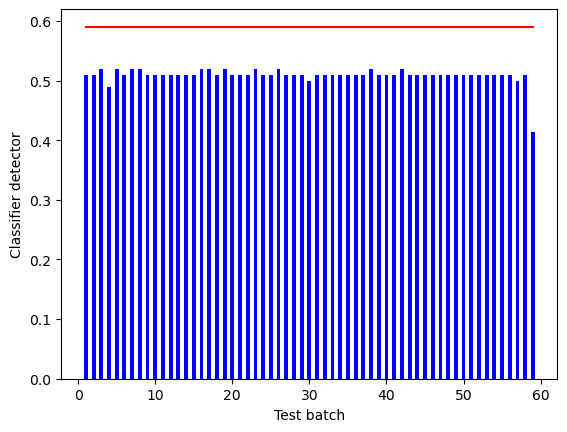

classifier_detector_all took 1.5482511520385742 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

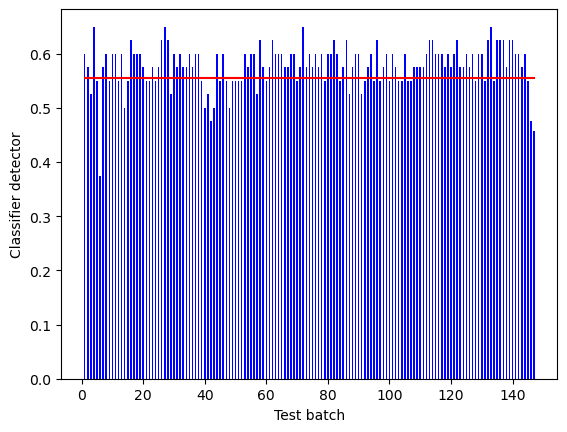

classifier_detector_all took 2.0402050018310547 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [1, 2, 4, 7, 8, 10, 11, 13, 16, 17, 18, 19, 20, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 44, 46, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 85, 86, 88, 89, 90, 93, 94, 96, 98, 99, 101, 102, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144] (0.6097560975609756, 0.7358490566037735)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583793  0.662706  0.435417  0.682719   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458926  0.331766   
2  0.427130  0.565700  0.559086  0.520828  0.768195  0.585949  0.265370   
3  0.585452  0.908633  0.334374  0.698671  0.636000  0.524502  0.591079   
4

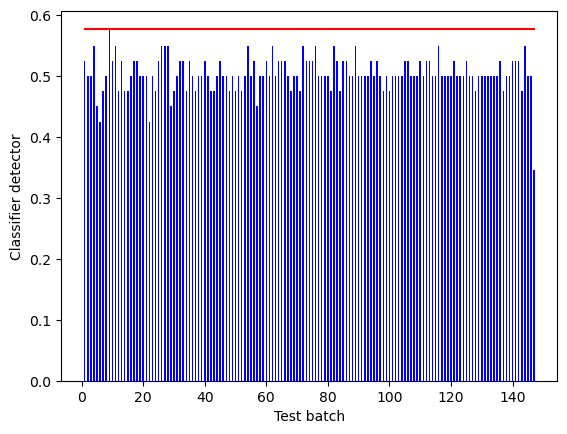

classifier_detector_all took 2.2668559551239014 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

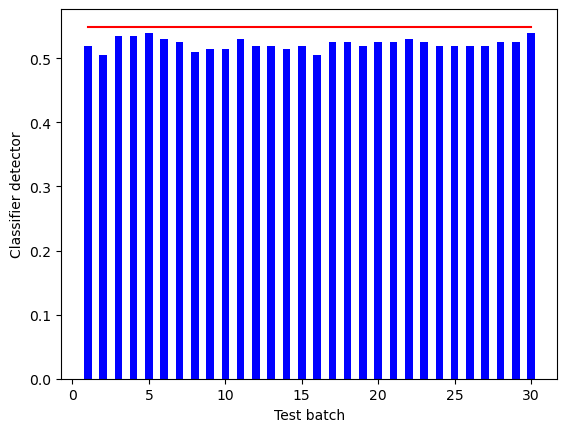

classifier_detector_all took 1.0422618389129639 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


200
         0         1         2         3         4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.381650  0.348510  0.269521   
1  0.405538  0.257814  0.523115  0.401890  0.462929  0.361941  0.159062   
2  0.334286  0.374569  0.529598  0.381037  0.442400  0.434514  0.138166   
3  0.449808  0.549951  0.316738  0.474980  0.366269  0.399407  0.240682   
4  0.130201  0.386035  0.449649  0.460950  0.421610  0.453861  0.197008   

         7         8         9   ...        90        91        92        93  \
0  0.282435  0.454929  0.450029  ...  0.450259  0.506741  0.784306  0.179765   
1  0.222085  0.567441  0.395513  ...  0.529148  0.520881  0.255688  0.283647   
2  0.226397  0.452984  0.383662  ...  0.547802  0.571239  0.515429  0.659153   
3  0.199681  0.289606  0.509541  ...  0.479501  0.598306  0.344459  0.47521

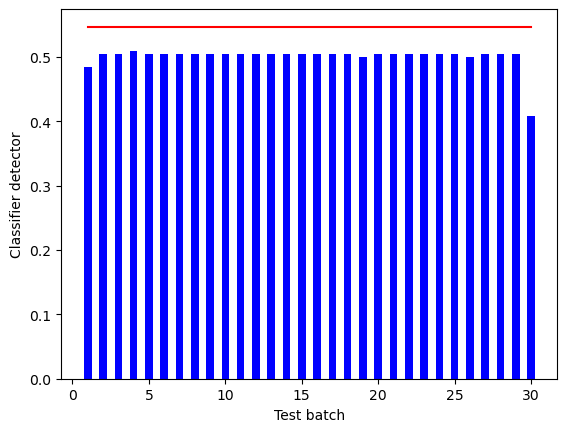

classifier_detector_all took 1.111618995666504 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

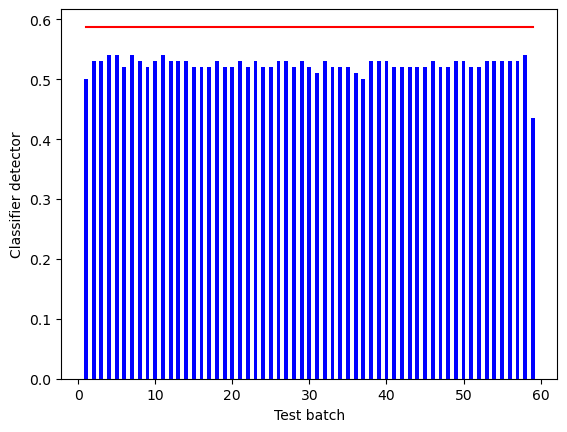

classifier_detector_all took 1.5948281288146973 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550653  0.662708  0.276325  0.635435   
1  0.396793  0.198283  0.552241  0.528499  0.803844  0.291245  0.375006   
2  0.322958  0.324403  0.559086  0.491263  0.768195  0.371859  0.325739   
3  0.442667  0.513852  0.334374  0.659010  0.636000  0.332863  0.567440   
4  0.111477  0.336788  0.474686  0.633958  0.732095  0.393351  0.464471   

         7         8         9   ...        90        91        92        93  \
0  0.469192  0.382287  0.570875  ...  0.724824  0.461670  0.778343  0.230230   
1  0.368940  0.509788  0.501726  ...  0.432802  0.512059  0.601646  0.514333   
2  0.376104  0.380079  0.486695  ...  0.550395  0.500029  0.494049  0.423329   
3  0.331719  0.194927  0.646388  ...  0.309560  0.582620  0.522573  0.317867

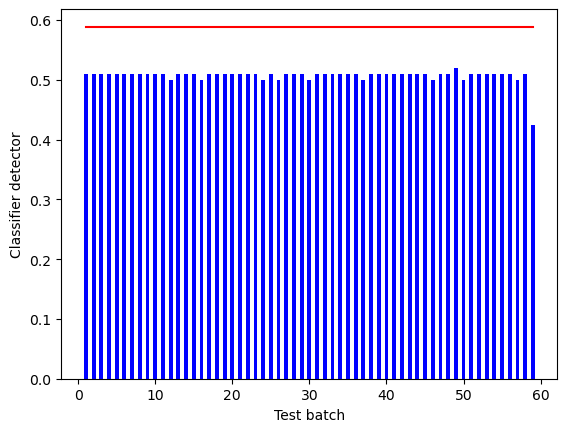

classifier_detector_all took 1.7211778163909912 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

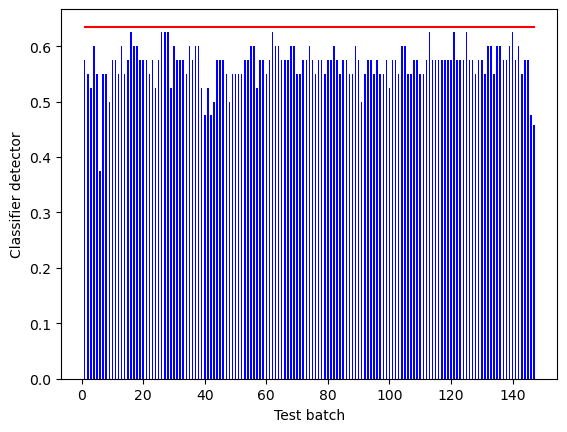

classifier_detector_all took 2.1418960094451904 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583793  0.662705  0.435418  0.682718   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458923  0.331769   
2  0.427130  0.565700  0.559086  0.520829  0.768194  0.585951  0.265377   
3  0.585452  0.908633  0.334374  0.698671  0.636000  0.524503  0.591084   
4  0.147434  0.588120  0.474686  0.672112  0.732094  0.619816  0.452326   

         7         8         9   ...        90        91        92        93  \
0  0.494448  0.356622  0.610596  ...  0.110605  1.115512  0.628110  0.568173   
1  0.388789  0.568534  0.533176  ...  0.504643  0.512682  0.369025  0.498361   
2  0.396337  0.352976  0.516364  ...  0.316505  0.635620  0.552758  0.358273   
3  0.349572  0.045278  0.695090  ...  0.371689  0.206290  0.456828  0.508852 

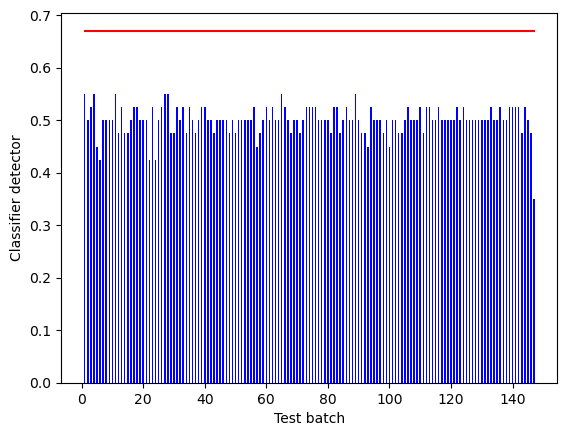

classifier_detector_all took 2.360257148742676 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0  

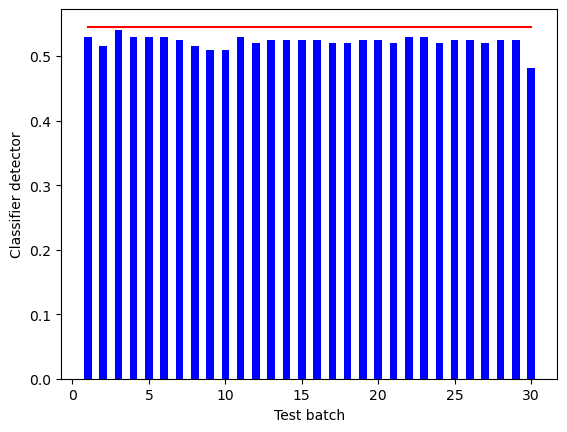

classifier_detector_all took 1.0644657611846924 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


200
         0         1         2         3         4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.381649  0.348510  0.269520   
1  0.405538  0.257814  0.523115  0.401890  0.462930  0.361940  0.159061   
2  0.334286  0.374569  0.529598  0.381037  0.442400  0.434514  0.138165   
3  0.449808  0.549951  0.316738  0.474980  0.366270  0.399408  0.240680   
4  0.130201  0.386035  0.449649  0.460950  0.421610  0.453862  0.197007   

         7         8         9   ...        90        91        92        93  \
0  0.282437  0.454924  0.450018  ...  0.862659  0.431473  0.179749  0.483189   
1  0.222084  0.567439  0.395506  ...  0.676462  0.594660  0.275623  0.500671   
2  0.226398  0.452982  0.383657  ...  0.515900  0.491267  0.420376  0.464326   
3  0.199680  0.289604  0.509544  ...  0.602751  0.610954  0.292540  0.36258

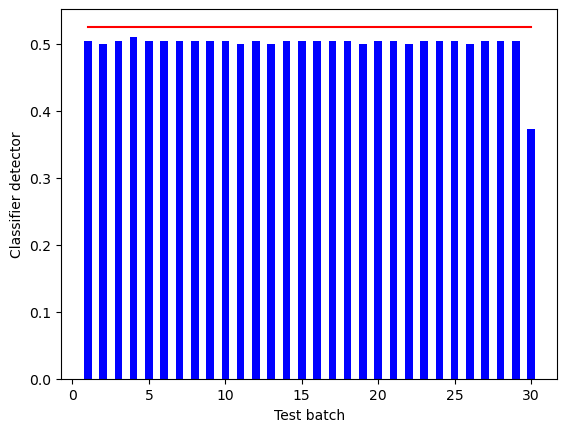

classifier_detector_all took 1.104522943496704 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

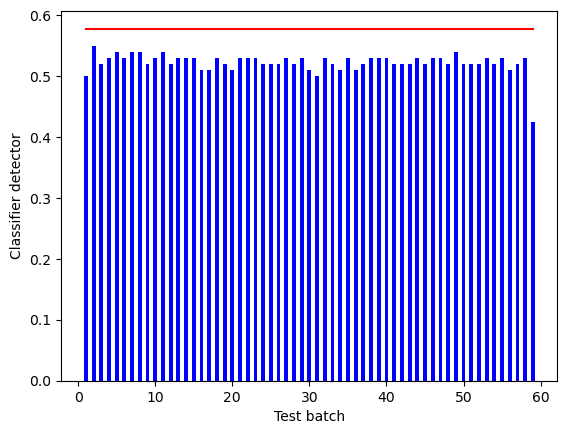

classifier_detector_all took 1.3382902145385742 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550654  0.662707  0.276326  0.635439   
1  0.396793  0.198283  0.552241  0.528499  0.803843  0.291244  0.375011   
2  0.322958  0.324403  0.559086  0.491263  0.768194  0.371858  0.325746   
3  0.442667  0.513852  0.334374  0.659010  0.636000  0.332863  0.567444   
4  0.111477  0.336788  0.474686  0.633958  0.732094  0.393350  0.464477   

         7         8         9   ...        90        91        92        93  \
0  0.469198  0.382280  0.570880  ...  0.415493  0.304314  0.842613  0.666263   
1  0.368938  0.509787  0.501730  ...  0.552308  0.310056  0.402872  0.504848   
2  0.376099  0.380082  0.486704  ...  0.516452  0.300003  0.353738  0.638289   
3  0.331718  0.194926  0.646378  ...  0.396441  0.286130  0.475634  0.466608

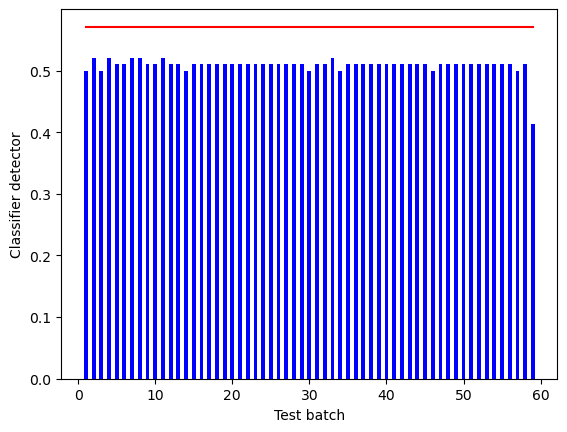

classifier_detector_all took 1.557110071182251 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0  

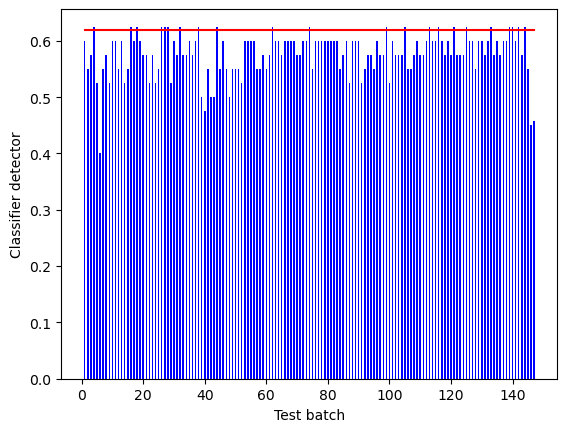

classifier_detector_all took 2.2750720977783203 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [4, 16, 18, 26, 27, 28, 32, 38, 44, 62, 74, 99, 105, 113, 116, 121, 125, 133, 139, 140, 142, 144] (0.17073170731707318, 0.14150943396226415)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583794  0.662707  0.435415  0.682712   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458924  0.331762   
2  0.427130  0.565700  0.559086  0.520829  0.768195  0.585949  0.265373   
3  0.585452  0.908633  0.334374  0.698671  0.636001  0.524502  0.591086   
4  0.147434  0.588120  0.474686  0.672112  0.732094  0.619814  0.452325   

         7         8         9   ...        90        91        92        93  \
0  0.494443  0.356638  0.610586  ...  0.219675  0.599868  0.579193  0.739388   
1  0.388793  0.568529  0.533186  ...  0.507258  0.519771  0.432246  0.446669   
2  0.396336  0.352982  0.51635

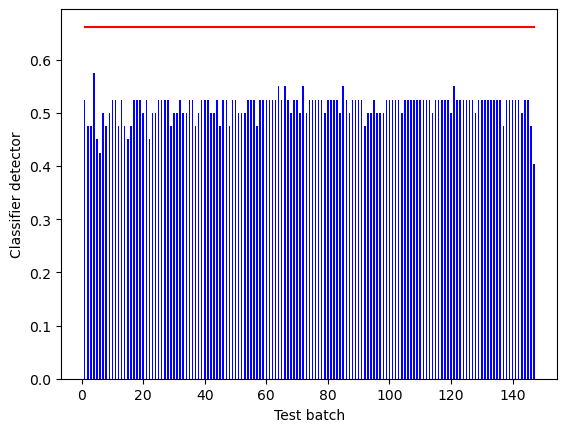

classifier_detector_all took 2.3574788570404053 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

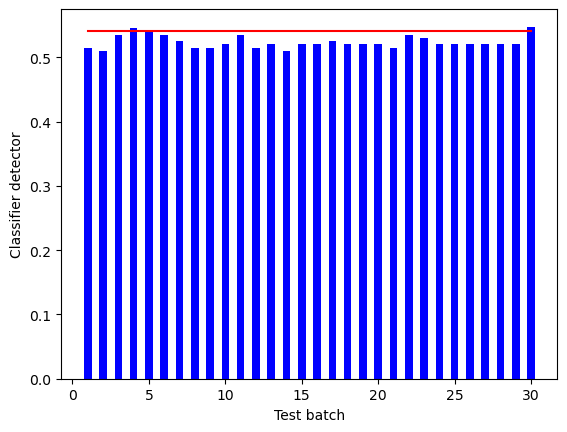

classifier_detector_all took 1.2483909130096436 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [4, 30] (0.5, 0.0)


200
         0         1         2         3         4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.381649  0.348510  0.269521   
1  0.405538  0.257814  0.523115  0.401890  0.462930  0.361940  0.159060   
2  0.334286  0.374569  0.529598  0.381037  0.442400  0.434514  0.138164   
3  0.449808  0.549951  0.316738  0.474980  0.366269  0.399407  0.240679   
4  0.130201  0.386035  0.449649  0.460950  0.421610  0.453861  0.197005   

         7         8         9   ...        90        91        92        93  \
0  0.282434  0.454923  0.450018  ...  0.551697  0.678518  0.639764  0.806721   
1  0.222082  0.567438  0.395508  ...  0.333568  0.544535  0.453501  0.468549   
2  0.226396  0.452981  0.383663  ...  0.373082  0.707690  0.607008  0.569571   
3  0.199679  0.289602  0.509542  ...  0.345418  0.786539  0.463628  0.

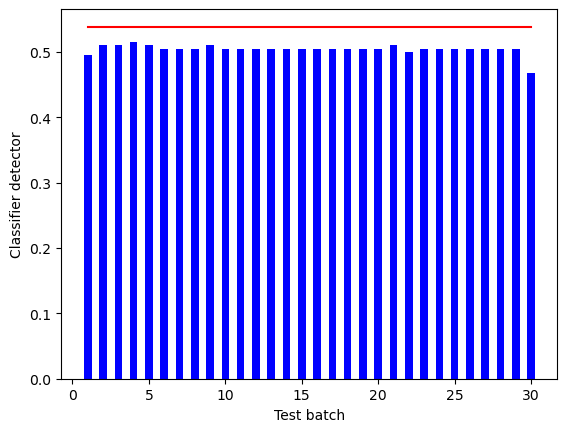

classifier_detector_all took 1.4907610416412354 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0

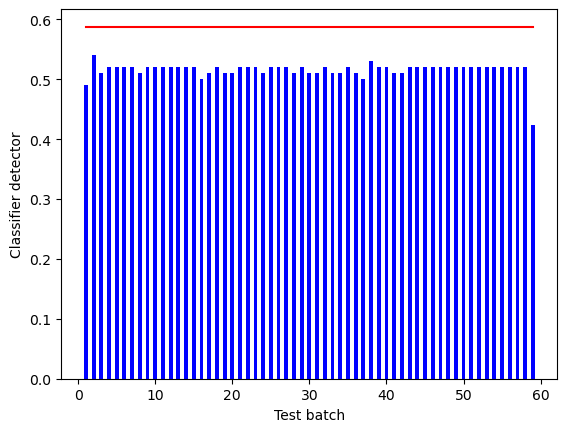

classifier_detector_all took 1.3877480030059814 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550654  0.662704  0.276327  0.635435   
1  0.396793  0.198283  0.552241  0.528499  0.803841  0.291245  0.375010   
2  0.322958  0.324403  0.559086  0.491263  0.768195  0.371858  0.325743   
3  0.442667  0.513852  0.334374  0.659010  0.635998  0.332862  0.567443   
4  0.111477  0.336788  0.474686  0.633959  0.732092  0.393350  0.464476   

         7         8         9   ...        90        91        92        93  \
0  0.469199  0.382281  0.570879  ...  0.183361  0.761384  0.476782  1.133280   
1  0.368945  0.509786  0.501728  ...  0.646147  0.551216  0.496991  0.689315   
2  0.376106  0.380079  0.486696  ...  0.434526  0.609264  0.322574  0.510755   
3  0.331728  0.194926  0.646385  ...  0.476610  0.767684  0.503633  0.482037

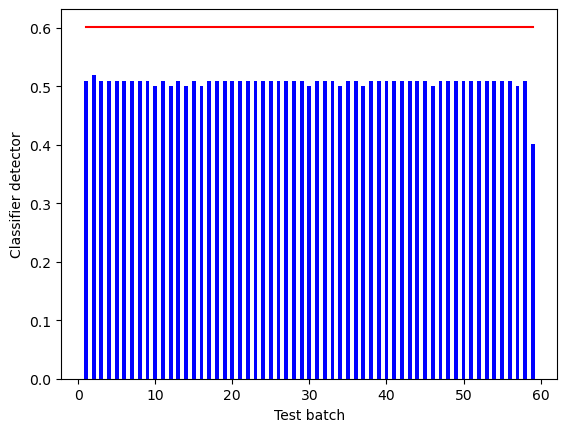

classifier_detector_all took 1.6909260749816895 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

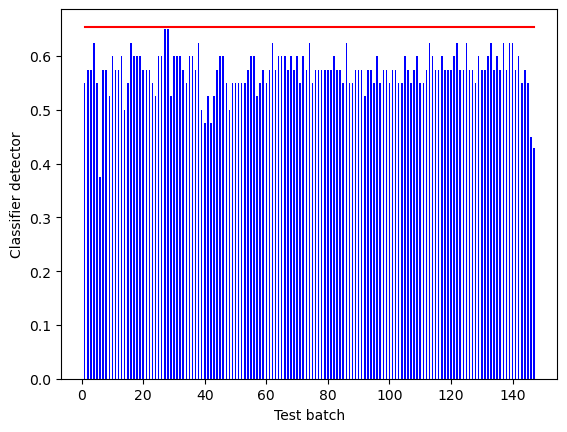

classifier_detector_all took 2.2106211185455322 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583794  0.662707  0.435416  0.682716   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458924  0.331766   
2  0.427130  0.565700  0.559086  0.520829  0.768195  0.585948  0.265376   
3  0.585452  0.908633  0.334374  0.698671  0.636000  0.524503  0.591085   
4  0.147434  0.588120  0.474686  0.672112  0.732095  0.619814  0.452326   

         7         8         9   ...        90        91        92        93  \
0  0.494447  0.356640  0.610592  ...  0.305394  0.672279  0.166353  0.537075   
1  0.388794  0.568525  0.533183  ...  0.423794  0.627379  0.599189  0.547018   
2  0.396342  0.352976  0.516365  ...  0.404562  0.546505  0.539602  0.698755   
3  0.349571  0.045284  0.695096  ...  0.414282  0.781536  0.686425  0.455281 

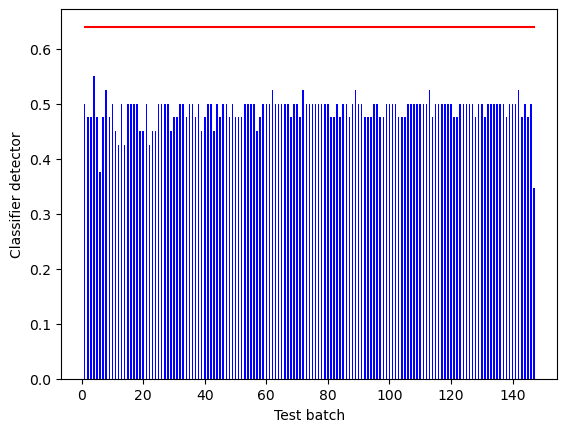

classifier_detector_all took 2.091644287109375 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0  

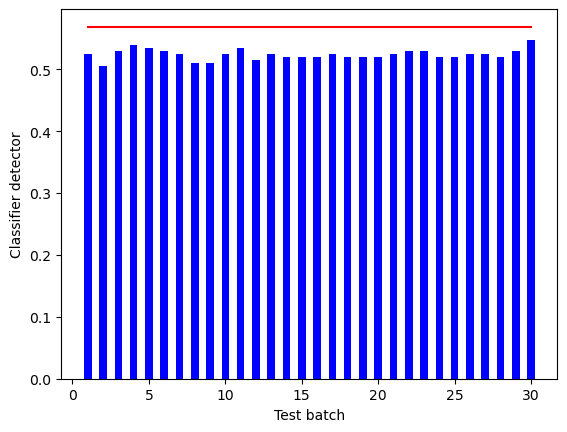

classifier_detector_all took 1.005965232849121 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


200
         0         1         2         3        4         5         6   \
0  0.311369  0.169698  0.308722  0.414297  0.38165  0.348510  0.269515   
1  0.405538  0.257814  0.523115  0.401890  0.46293  0.361941  0.159056   
2  0.334286  0.374569  0.529598  0.381037  0.44240  0.434513  0.138159   
3  0.449808  0.549951  0.316738  0.474980  0.36627  0.399407  0.240677   
4  0.130201  0.386035  0.449649  0.460951  0.42161  0.453861  0.197002   

         7         8         9   ...        90        91        92        93  \
0  0.282435  0.454925  0.450025  ...  0.103742  0.382293  0.695624  0.438754   
1  0.222085  0.567438  0.395507  ...  0.512387  0.438078  0.542810  0.585353   
2  0.226396  0.452985  0.383659  ...  0.541356  0.568632  0.496276  0.444302   
3  0.199683  0.289606  0.509540  ...  0.437295  0.359030  0.336061  0.646568   
4 

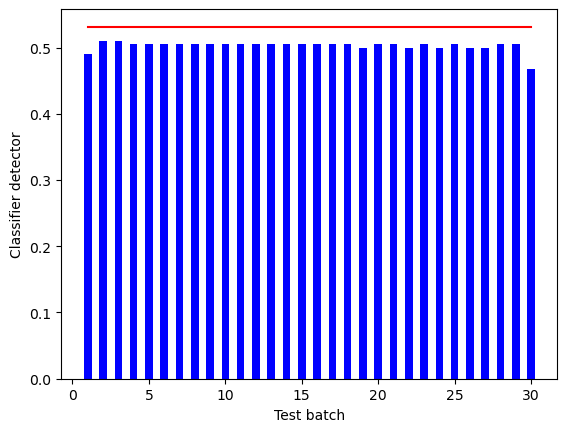

classifier_detector_all took 1.228010892868042 seconds

 real_world_data/spam_dataset.csv 100 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0 

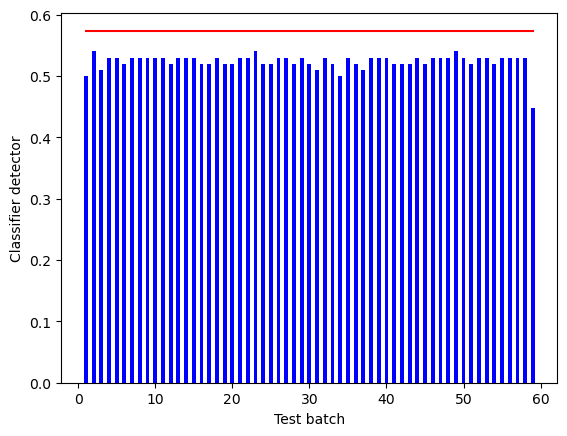

classifier_detector_all took 1.2727339267730713 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: None
Classifier: [] (0.0, 0.0)


100
         0         1         2         3         4         5         6   \
0  0.299211  0.103099  0.325911  0.550654  0.662706  0.276327  0.635442   
1  0.396793  0.198283  0.552241  0.528499  0.803842  0.291245  0.375011   
2  0.322958  0.324403  0.559086  0.491263  0.768194  0.371859  0.325744   
3  0.442667  0.513852  0.334374  0.659010  0.635999  0.332863  0.567445   
4  0.111477  0.336788  0.474686  0.633959  0.732094  0.393350  0.464478   

         7         8         9   ...        90        91        92        93  \
0  0.469202  0.382282  0.570883  ...  0.986336  0.691968  0.689572  0.420332   
1  0.368945  0.509788  0.501724  ...  0.434642  0.548716  0.407981  0.520977   
2  0.376100  0.380083  0.486686  ...  0.477401  0.658796  0.686606  0.502130   
3  0.331719  0.194928  0.646380  ...  0.420101  0.720444  0.459786  0.488236

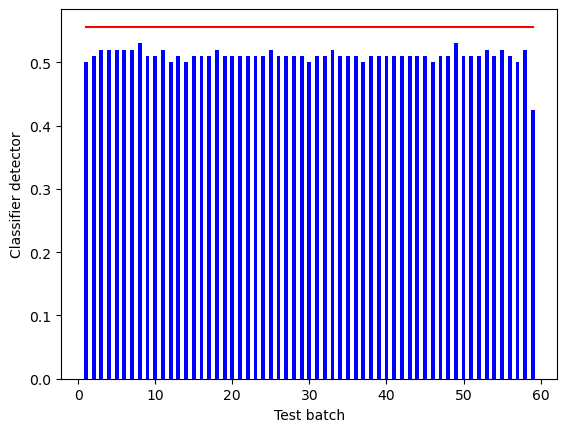

classifier_detector_all took 1.401540756225586 seconds

 real_world_data/spam_dataset.csv 50 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)


       aa  aba  abandon  abb  abbey  abbrevi  abdomin  abduct  aberr  abid  \
0     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
2     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
3     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
4     0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
...   ...  ...      ...  ...    ...      ...      ...     ...    ...   ...   
1463  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1464  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1465  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0   0.0   
1466  0.0  0.0      0.0  0.0    0.0      0.0      0.0     0.0    0.0  

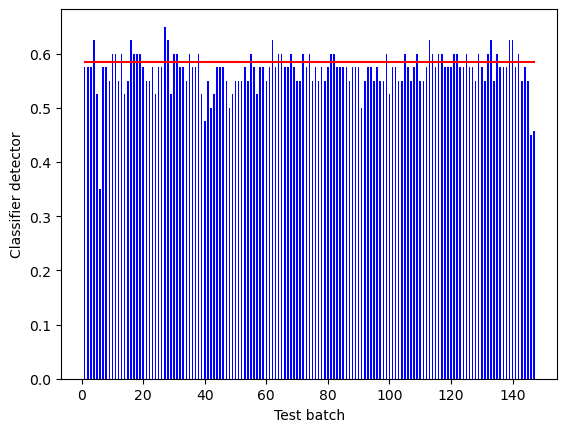

classifier_detector_all took 1.8518860340118408 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: None
Classifier: [4, 10, 11, 13, 16, 17, 18, 19, 27, 28, 30, 31, 35, 38, 55, 62, 64, 65, 68, 72, 74, 81, 82, 99, 105, 109, 113, 114, 116, 117, 121, 122, 125, 129, 132, 133, 135, 139, 140, 142] (0.24390243902439024, 0.2830188679245283)


40
         0         1         2         3         4         5         6   \
0  0.395724  0.165107  0.325911  0.583794  0.662706  0.435416  0.682716   
1  0.524781  0.337404  0.552241  0.560305  0.803843  0.458924  0.331769   
2  0.427130  0.565700  0.559086  0.520829  0.768195  0.585950  0.265377   
3  0.585452  0.908633  0.334374  0.698671  0.636000  0.524502  0.591081   
4  0.147434  0.588120  0.474686  0.672112  0.732094  0.619815  0.452328   

         7         8         9   ...        90        91        92        93  \
0  0.494444  0.356628  0.610583  ...  0.322137  0.380068  0.776923  0.575009   
1  0.388792  0.568529  0.533186  

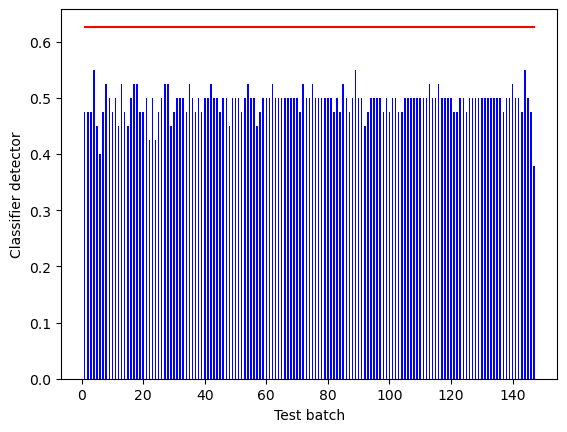

classifier_detector_all took 2.071769952774048 seconds

 real_world_data/spam_dataset.csv 20 encoder: None scaler: minmax
Classifier: [] (0.0, 0.0)




In [12]:
def run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler=None):
    ref_data = X_train
    test_batches = X_test_batches
    ref_labels = y_train
    
#     timer = time()
#     drifts_pca_ref = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_pca_all took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_ref = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_stat_all took", time() - timer, "seconds")
    
#     drifts_scd_unidir = []
#     if encoder != "onehot": # due to matrix errors
#         timer = time()
#         drifts_scd_unidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler)
#         print("scd_all took", time() - timer, "seconds")

#     drifts_scd_bidir = []
#     if encoder != "onehot": # due to matrix errors
#         timer = time()
#         drifts_scd_bidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler, bidirectional=True)
#         print("scd_all (bidir) took", time() - timer, "seconds")

    timer = time()
    drifts_classifier = classifier_detector_all(ref_data, test_batches, ref_labels, encoder, scaler)
    print("classifier_detector_all took", time() - timer, "seconds")

    print("\n", filename, "encoder:", encoder, "scaler:", scaler)
    report_1 = [
#         "PCA_ref:",
#         drifts_pca_ref,
#         postprocess_rw(real_drifts, drifts_pca_ref, len(test_batches)),
#         "Stat_ref:",
#         drifts_stat_ref,
#         postprocess_rw(real_drifts, drifts_stat_ref, len(test_batches)),
#         "SCD_unidir:",
#         drifts_scd_unidir,
#         postprocess_rw(real_drifts, drifts_scd_unidir, len(test_batches)),
        "Classifier:",
        drifts_classifier,
        postprocess_rw(real_drifts, drifts_classifier, len(test_batches))
    ]
    report_2 = [
#         "SCD_bidir:",
#         drifts_scd_bidir,
#         postprocess_rw(real_drifts, drifts_scd_bidir, len(test_batches))
    ]

    print(*report_1)
    print(*report_2, "\n")
    

def run_airlines():
    filename = "real_world_data/airline_dataset.csv"

    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    train = df.iloc[:179794,:]
    test = df.iloc[179794:,:]
    
    X_train = train.drop(columns=["Delay", "Unnamed: 0"])
    X_test = test.drop(columns=["Delay", "Unnamed: 0"])
    y_train = train[["Delay"]]
    y_test = test[["Delay"]]
    
    X_test_batches = []

    i = 0
    while i < len(X_test):
        new_i = i + 17000
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    # See drift definitions
    real_drifts = [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22]

    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="onehot", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="onehot", scaler="minmax")
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="ordinal", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="ordinal", scaler="minmax")
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="target", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="target", scaler="minmax")

    
def run_elect2():
    filename = "real_world_data/electricity_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data).drop(columns=["Unnamed: 0", "real_date"])
    
    df["day"] = df["day"].apply(lambda x: float(x.split("\'")[1]))
    
    print(df)
    print(np.linalg.matrix_rank(df))
    
    train = df.iloc[:15104,:]
    test = df.iloc[15104:,:]
    
    X_train = train.drop(columns=["label"])
    X_test = test.drop(columns=["label"])

    y_train = train[["label"]]
    y_test = test[["label"]]

    # Preprocess with PCA to avoid linear algebra errors in SCD
    pca = PCA()
    X_train = pd.DataFrame(pca.fit_transform(X_train))
    X_test = pd.DataFrame(pca.transform(X_test))
    
    print(X_train)
    print(np.linalg.matrix_rank(X_train))
    
    X_test_batches = []

    i = 0
    while i < len(X_test):
        new_i = i + 365
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
    
    real_drifts = [2,4,11,12,13,14,15,16,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,59,60,62,63,65,66,67,76,80,81,83]
    
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler="minmax")
    
    
def run_weather(monthly):
    filename = "real_world_data/weather_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    
    train = df.iloc[:6053,:]
    test = df.iloc[6053:,:]
    
    X_train = train.drop(columns=["Label_Rain", "Unnamed: 0"])
    X_test = test.drop(columns=["Label_Rain", "Unnamed: 0"])
    
    y_train = train[["Label_Rain"]]
    y_test = test[["Label_Rain"]]
    
    batch_size = 365
    label = filename + " yearly"
    real_drifts = [ 2, 3, 4, 6, 11, 12, 15, 16, 17, 18, 22, 24, 25, 27, 28, 29, 32, 33 ]
    if monthly:
        batch_size = 30
        label = filename + " monthly"
        real_drifts = [11,12,14,18,28,31,35,43,47,48,49,69,92,96,103,108,125,143,145,147,154,162,167,173,174,175,176,177,178,183,185,186,192,197,205,209,210,214,215,217,220,228,246,247,260,265,266,281,283,284,297,302,319,322,323,324,327,335,338,350,353,357,362,383,384,387,389,397,399,400]
        
    # Preprocess with PCA to avoid linear algebra errors in SCD
    pca = PCA()
    X_train = pd.DataFrame(pca.fit_transform(X_train))
    X_test = pd.DataFrame(pca.transform(X_test))
    
    X_test_batches = []
    
    i = 0
    while i < len(X_test):
        new_i = i + batch_size
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler="minmax")
    
    
def run_spam(batch_size):
    filename = "real_world_data/spam_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data).drop(columns=["Unnamed: 0"])
    
    train = df.iloc[:1468,:]
    test = df.iloc[1468:,:]
    
    X_train = train.drop(columns=["ACTUAL_LABEL"])
    X_test = test.drop(columns=["ACTUAL_LABEL"])
    
    print(X_train)
    print(np.linalg.matrix_rank(X_train))
    
    y_train = train[["ACTUAL_LABEL"]]
    y_test = test[["ACTUAL_LABEL"]]
    
    # Preprocess with PCA to avoid linear algebra errors in SCD
    pca = PCA(n_components=100)
    X_train = pd.DataFrame(pca.fit_transform(X_train))
    X_test = pd.DataFrame(pca.transform(X_test))
    
    X_test_batches = []
    
    i = 0
    while i < len(X_test):
        new_i = i + batch_size
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    print("batches:", len(X_test_batches))
    
    real_drifts = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
    if batch_size == 50:
        real_drifts = [1, 3, 4, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
    elif batch_size == 20:
        real_drifts = [2, 10, 11, 14, 17, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 70, 72, 73, 74, 76, 77, 78, 79, 80, 82, 83, 85, 86, 87, 88, 90, 92, 93, 95, 97, 98, 99, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145]
    
    label = filename + " " + str(batch_size)
        
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler="minmax")
    
# run_airlines()
run_elect2()
run_weather(monthly=True)
run_weather(monthly=False)
for i in range(10):
    run_spam(batch_size=100)
    run_spam(batch_size=50)
    run_spam(batch_size=20)

In [ ]:
# For developing the stat/crit graphs

# deltas = [-500, -112.33805834087934, -5.63757670366158, -254.64638163367908, -105.95361974932212, -277.2522005160049, -0.7797701869503726, -17.160444052856292, 0.6515078028928656, -500, 81.65627519798909, -251.6647424837547, -104.890988106441, -500, -362.3305095837991, -155.8376577058052, -153.27112026764098, 104.28955944645986, 103.35571477773283, -198.54996551748536, -9.33669177511274, -139.4456957732, -500, -500, -164.03845542809495, -203.69279570797062, -309.29205775200353, 30.91586674598011, -221.1829434006777, -71.75523475546379, -0.4561412892317094, 180.17201171699162, -180.71892697522435, -92.823026451837]
# crits = [-112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -44.02884159020756]
# y_label = "SCD (unidirectional)"
# deltas_reverse = [-626.5247613554766, 462.732832569769, 1228.4724605070069, 1428.1028153758189, 1252.3197326216869, -2360.207044655568, -2482.9791209586383]
# crits_reverse = [-1722.3482489631685, -1709.2903407223453, -1790.3885036189583, -1784.6916262708824, -1774.6846479583753, -1828.9015713027097, -1820.821524179729]

# graph(deltas, crits, y_label)
